## Import libraries

In [1]:
import glob
import sys
import warnings

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import copy
import time

from IPython import display as ipd
from PIL import Image

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder,  DatasetFolder,VisionDataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import os
import torchvision.models as models

%matplotlib inline
warnings.filterwarnings("ignore")

import torchaudio
#from pydub import AudioSegment
from IPython import display
import random
import wandb
from scipy.optimize import brentq
from scipy.interpolate import interp1d

C:\Users\79671\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Config

In [2]:
class CFG:
    JUST_PREDICT  = False
    Kaggle        = False 
    DEBUG         = False
    FULL_DATA     = True
    wandb_on      = False
    seed          = 101
    MULTIMODEL    = False
    weights       = 'imagenet'
    backbone      = 'efficientnet-b1'
    model_name    = 'eff_net_b1'
    archive_name  = 'Audio'
    models        = []
    optimizers    = []
################################################### 
    num_of_models = 1
    model_number  = 1
    train_bs      = 32
    valid_bs      = 32
    width         = 300 # image width
    mels          = 80  # height
    SAMPLE_RATE   = 16000
    NUM_SAMPLES   = 48000
    num_item_all  = 5000 if DEBUG else 45235     #45235
    num_test      = 10 if DEBUG else 301      # 1000
    print_every   = 1  if DEBUG else 50      #500
    epochs        = 25  if DEBUG else 90        #35
    ###############################################
    crop_koef     = 1
    lr            = 0.002
    num_workers   = 4 if Kaggle else 0
    criterion     = nn.CrossEntropyLoss()
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 2
    classes       = [0,1]
    activation    = None #'softmax'
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    test_path     = " " if Kaggle else "E:/Audio/ASV/clips/"
    save_path     = '../working/result/' if Kaggle else "./result/"
    train_path    = "E:/Audio/ASV/clips/"
    csv_path      = 'E:/Audio/ASV/equal_dataset' 
    best_model_w  = 'C:/Users/79671/Desktop/ML/Deep_Fake/Important_rezulsts/Last_epoch_of_eff_net_b1.bin' if Kaggle else 'C:/Users/79671/Desktop/ML/Deep_Fake/Important_rezulsts/Last_epoch_of_eff_net_b1.bin'


In [3]:
try:
    wandb.login(key='411cb1a6772ab39c9283d4f54778064f0be42b74')
    #wandb login 411cb1a6772ab39c9283d4f54778064f0be42b74
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: ilyamironov210202 (kode-ai). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\79671/.netrc


In [4]:
print(CFG.device)

cuda


In [5]:
# Different classes dataset. 
classes = ('0','1')

## Read data

In [6]:

data = pd.read_csv(CFG.csv_path, sep = '\t' ) #pd.read_csv(CFG.csv_path, sep = '\\t', header=None)

In [7]:
data.head(10)

path  fake
0  DF_E_2000053     0
1  DF_E_2000058     0
2  DF_E_2000079     0
3  DF_E_2000246     0
4  DF_E_2000503     0
5  DF_E_2000508     0
6  DF_E_2000531     0
7  DF_E_2000676     0
8  DF_E_2001149     0
9  DF_E_2001163     0

<AxesSubplot:xlabel='fake', ylabel='Count'>

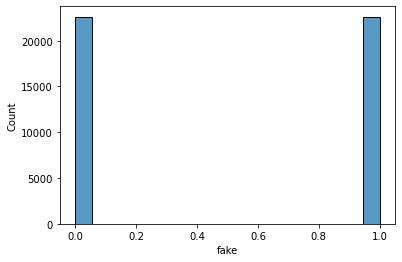

In [8]:
sns.histplot(data=data['fake'])

In [9]:
data['fake'].value_counts()

1    22618
0    22617
Name: fake, dtype: int64

In [10]:
 data.shape

(45235, 2)

In [11]:
sum(data['fake'].isnull())

0

In [12]:
#from torchaudio.io import StreamReader
from IPython import display

## Audio Augmentations

In [13]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=CFG.SAMPLE_RATE,
    n_fft=1024,
    win_length = 1024,
    hop_length=256,
    n_mels= CFG.mels,
    window_fn = torch.hann_window,
    center=False
)

MFCC_spectrogram = torchaudio.transforms.MFCC(
    sample_rate=CFG.SAMPLE_RATE,
    n_mfcc = CFG.mels,
    melkwargs={
        "n_fft": 1024,
        "n_mels": CFG.mels,
        "hop_length": 256,
        "mel_scale": "htk",
        'win_length': 1024,
        'window_fn': torch.hann_window,
        'center':False
    },
)

## Dataset class

In [14]:
class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                lable = False):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.lable = lable

    def __len__(self):
        return len(self.audio_dir)

    def __getitem__(self, index):
        #print(index)
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self.transformation(signal)
        #signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        #signal = signal.repeat(3, 1, 1)
        #signal = torch.squeeze(signal)
        #signal = self.transformation(signal)
        if self.lable == True: # WHEN WE TRAIN
            label = self._get_audio_sample_label(index)
            return signal, label
        else: # WHEN WE PREDICT
            return signal, torch.randint(0, 1, (1,))

    def _cut_if_necessary(self, signal):
        if signal.shape[2] > CFG.width:
            signal = signal[:, :, 0:CFG.width]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[2]
        if length_signal < CFG.width:
            num_missing_samples = CFG.width - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = self.audio_dir[index]
        if self.lable == True:
            path = os.path.join(CFG.train_path,path)
        else:
            path = os.path.join(CFG.test_path,path)
        path = path + '.flac'
        return path

    def _get_audio_sample_label(self, index):
        path = self.audio_dir[index]
        #print(path)
        df = self.annotations
        df = df.loc[lambda df: df['path'] == path]
        #print(df.head())
        num = list(df['fake'])
        #print(num)
        return torch.Tensor(num)




In [15]:
def prepare_loaders():
    audio_names = pd.read_csv(CFG.csv_path, sep = '\t' )
    audio_names = list(audio_names['path'])
    #audio_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.train_path)] #[os.path.join("./train/",item_name)  for item_name in os.listdir(CFG.train_path)]
    random.shuffle(audio_names)
    audio_names = audio_names[:CFG.num_item_all]
    print(f'Number of items we work with:{len(audio_names)}')
    audio_train_valid, audio_test = train_test_split(audio_names, test_size=0.2 ,   random_state= CFG.seed)
    audio_train, audio_valid = train_test_split(audio_train_valid, test_size=0.25 , random_state= CFG.seed)
    #print(type(train_ids))
    #print(valid_ids)
    train_dataset = UrbanSoundDataset(data, audio_train, MFCC_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    valid_dataset = UrbanSoundDataset(data, audio_valid, MFCC_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    test_dataset  = UrbanSoundDataset(data, audio_test, MFCC_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
    return train_loader, valid_loader , test_loader

## Visualization

In [16]:
def Melspectrogram_visualize(array: torch.Tensor):
    #print(array.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(array.squeeze().log())
    plt.xlabel('Time', size=20)
    plt.ylabel('Frequency (Hz)', size=20)
    plt.show()

    
    
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [17]:
from typing import List , Tuple

In [18]:
train_loader, valid_loader, test_loader = prepare_loaders()

Number of items we work with:45235


In [19]:
len(train_loader) , len(valid_loader)

(849, 283)

In [20]:
audio = next(iter(train_loader))
#print(audio['wav'].shape)
#print(Class)


In [21]:
mel = audio[0][0]

In [22]:
mel.shape

torch.Size([1, 80, 300])

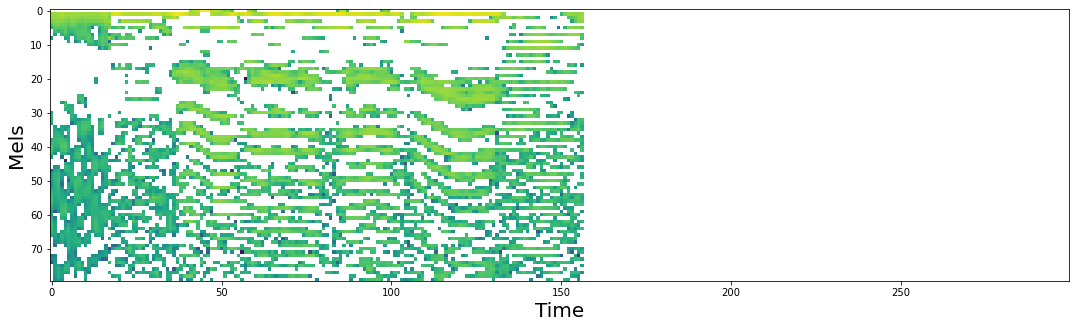

In [23]:
plt.figure(figsize=(20, 5))
plt.imshow(mel.permute(1,2,0).squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [24]:
mel.shape

torch.Size([1, 80, 300])

In [25]:
#Melspectrogram_visualize(audio)

In [26]:
#!pip install --upgrade efficientnet-pytorch

In [27]:
#############################################################################################################################
####################################################### BILSTM MODEL ########################################################
#############################################################################################################################
class BiLSTM(nn.Module):
    
    # define all the layers used in model
    def __init__(self, input_dim=80, hidden_size= 128):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_dim,
                           hidden_size=hidden_size,
                           num_layers = 1,
                           batch_first=True,
                           bidirectional = True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.clf = nn.Linear(hidden_size, 2)
        self._fc = torch.nn.Sequential(
    nn.Linear(in_features=256, out_features=128, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=64, out_features=2, bias=True))
        
    def forward(self, input, length = CFG.width - 1):
        # input: (batch_size, hidden_size, seq_len)
        out, _ = self.lstm(input.transpose(-1, -2))
        out = out[:,CFG.width - 1,:]
        # output: (batch_size, seq_len, hidden_size)
        
#         last_hidden = torch.gather(
#             output,
#             dim =1,
#             index = length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
#         )
        #logits = self.clf(last_hidden.squeeze(dim=1))
        #print(f'OUT SHAPE: {out.shape}')
        out = self._fc(out)
        return out
    

In [28]:
device = CFG.device

#from efficientnet_pytorch import EfficientNet
#model_name = 'efficientnet-b1'
#model = EfficientNet.from_pretrained(model_name).to(device)  #, num_classes=3

# for param in model.parameters():
#     param.requires_grad = False 
# model._fc = torch.nn.Sequential(
#     nn.Linear(in_features=1280, out_features=625, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=625, out_features=256, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Linear(in_features=256, out_features=2, bias=True))

model = BiLSTM().to(device)
#featurizer = Featurizer().to(device)
model.eval()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#optimizer = torch.optim.Adam(model._fc.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [29]:
model

BiLSTM(
  (lstm): LSTM(80, 128, batch_first=True, bidirectional=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (clf): Linear(in_features=128, out_features=2, bias=True)
  (_fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [30]:
# model.load_state_dict(torch.load(CFG.best_model_w , map_location=torch.device('cpu')))
# model.eval()
# model.to(CFG.device)

## Class for counting metrics

In [31]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Create directory for results

In [32]:
import shutil, os

try:
    if CFG.Kaggle:
        os.mkdir('../working/result')
        print('KAGGLE DIR CREATED')
    else:
        #shutil.rmtree('./result')
        local_time = time.ctime().replace(' ', '_').replace(':', '.')
        directory = f'../results/result_{CFG.model_name}_{local_time}'
        os.mkdir(directory)
        print('PC DIR CREATED')
except Exception:
    print("DIR NOT CREATED")
    pass

PC DIR CREATED


In [33]:
from collections import defaultdict

In [34]:
storage = defaultdict(list)

## EER CODE

In [35]:
def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size # sum of sizes 
    all_scores = np.concatenate((target_scores, nontarget_scores)) # vector of scores
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size))) # vextor of labels
    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort') # retern indexes of sorted array of zeros and ones
    labels = labels[indices] # and sort labels like (zeros and ones) for all 0 in both arrays and (zeros + ones) of 1 in both arrays

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels) # array with max element N
    # (np.arange(1, n_scores + 1, step = 1) - tar_trial_sums | gives array of element with max el = N
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1, step = 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds

def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs) # return index of min element
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

def minDCF(confusion_matrix):
# 0 -Real | 1 - Sintesized
# FAR - поставили 0 вместо 1
# FRR - поставили 1 вместо 0
    Pfar =  confusion_matrix[1][0] /(confusion_matrix[1][0] + confusion_matrix[0][1] + confusion_matrix[0][0] + confusion_matrix[1][1])
    Pfrr =  confusion_matrix[0][1] /(confusion_matrix[1][0] + confusion_matrix[0][1] + confusion_matrix[0][0] + confusion_matrix[1][1])
    mDCF = (0.01 * Pfar + 0.1 * Pfrr) * 100
    return mDCF


## Создание файла для ведения статистики

In [36]:
f = open(f'{directory}/Stats', 'w')

In [37]:
#f.write('\n\n\n')

# Wandb

In [38]:

if not CFG.DEBUG:
    run = wandb.init(project='CNN_B2_training',                      
                          anonymous=anonymous,
                          name=f"model-{CFG.model_name}, Epochs: {CFG.epochs}, Samples: {CFG.num_item_all} ",                  
                         )
    
    wandb.config.epochs = CFG.epochs
    wandb.config.train_batch_size = CFG.train_bs
    wandb.config.valid_batch_sizw = CFG.valid_bs
    wandb.config.samples = CFG.num_item_all
    wandb.config.Debug = CFG.DEBUG
    wandb.config.sr = CFG.SAMPLE_RATE
    wandb.config.lr = CFG.lr



# Training of model

Epoch: 1/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0 ---> 0.5251464573496598 !
Confusion Matrix of all:[[ 469 4016]
 [ 280 4282]]
minDCF : 4.469990051950923% 
EER : 48.72655508981866%


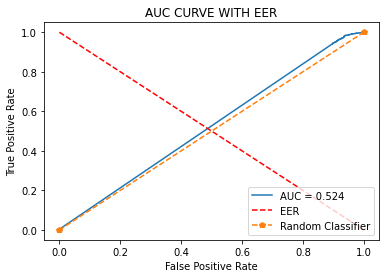

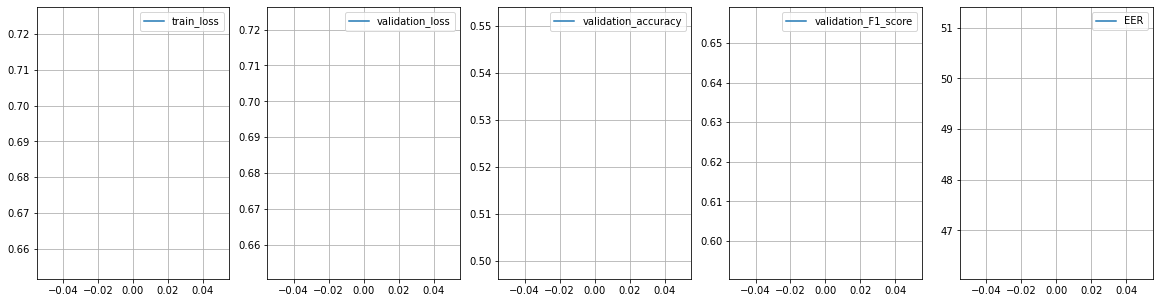

Epoch: 2/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4447   38]
 [4421  141]]
minDCF : 0.5306731513208799% 
EER : 48.77498736229302%


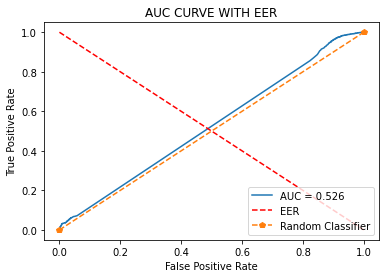

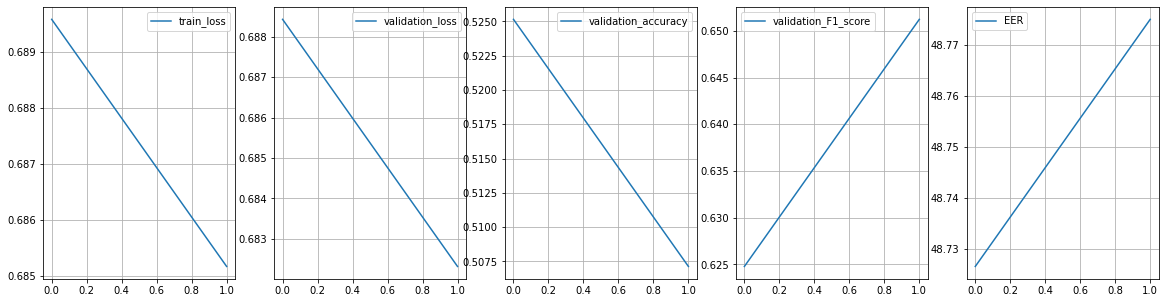

Epoch: 3/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.5251464573496598 ---> 0.5343207692762653 !
Confusion Matrix of all:[[ 453 4032]
 [ 181 4381]]
minDCF : 4.476732618547585% 
EER : 47.52955679331302%


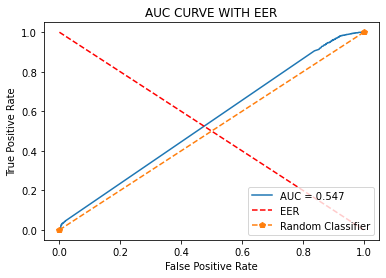

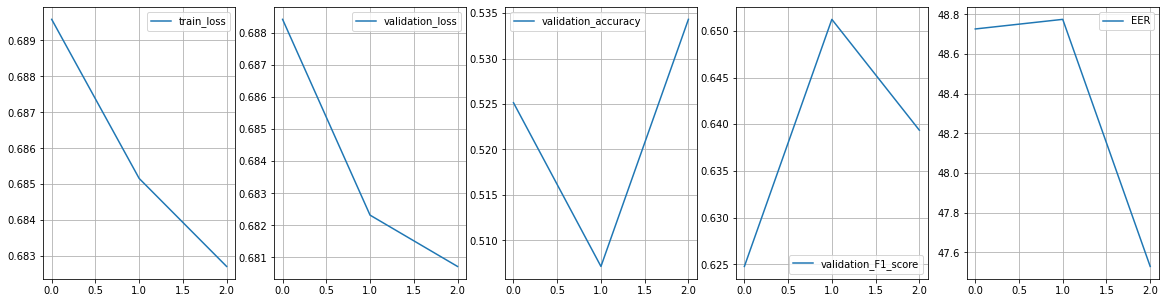

Epoch: 4/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.5343207692762653 ---> 0.5429424118097018 !
Confusion Matrix of all:[[ 543 3942]
 [ 193 4369]]
minDCF : 4.37857853432077% 
EER : 47.19825202746289%


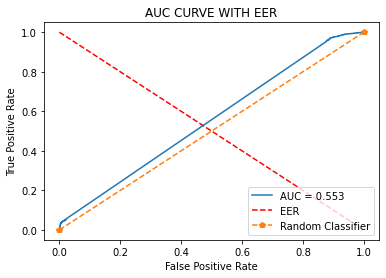

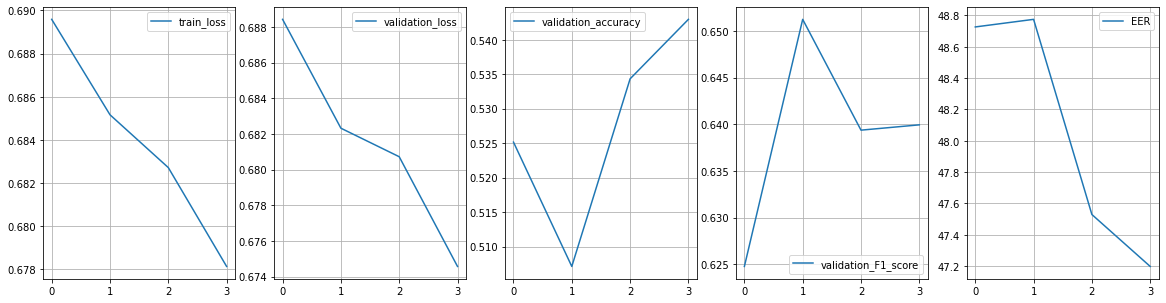

Epoch: 5/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.5429424118097018 ---> 0.6693931689667705 !
Confusion Matrix of all:[[2143 2342]
 [ 649 3913]]
minDCF : 2.660439924836963% 
EER : 33.4671125976304%


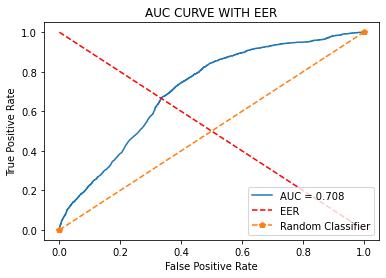

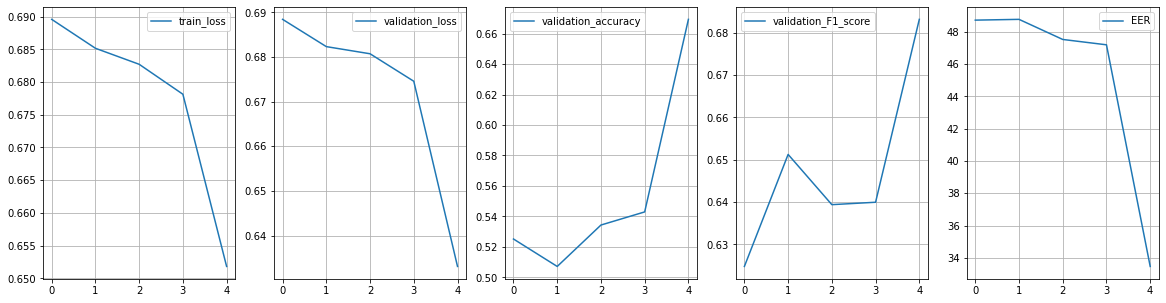

Epoch: 6/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[ 876 3609]
 [ 198 4364]]
minDCF : 4.01105338786338% 
EER : 45.03220541456839%


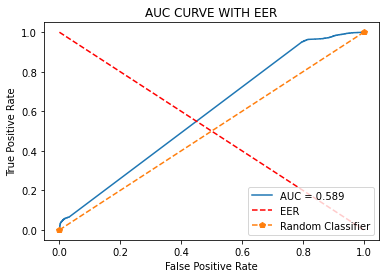

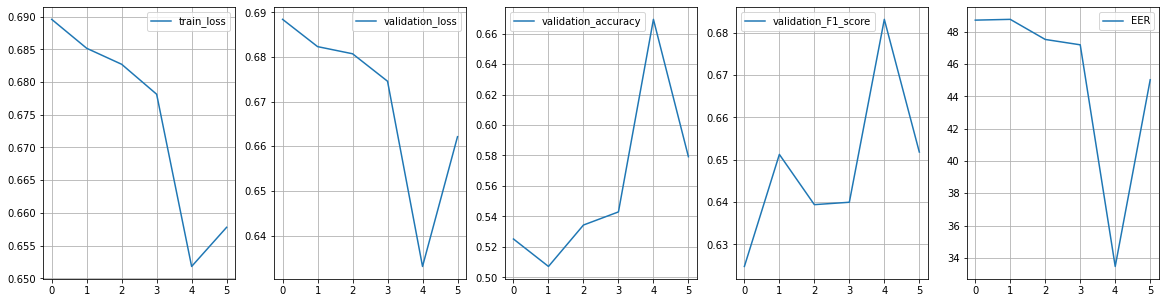

Epoch: 7/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.6693931689667705 ---> 0.6997899856635375 !
Confusion Matrix of all:[[2092 2393]
 [ 323 4239]]
minDCF : 2.680778158505582% 
EER : 35.72147387206119%


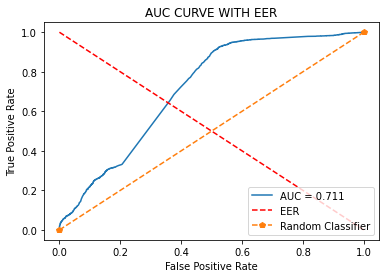

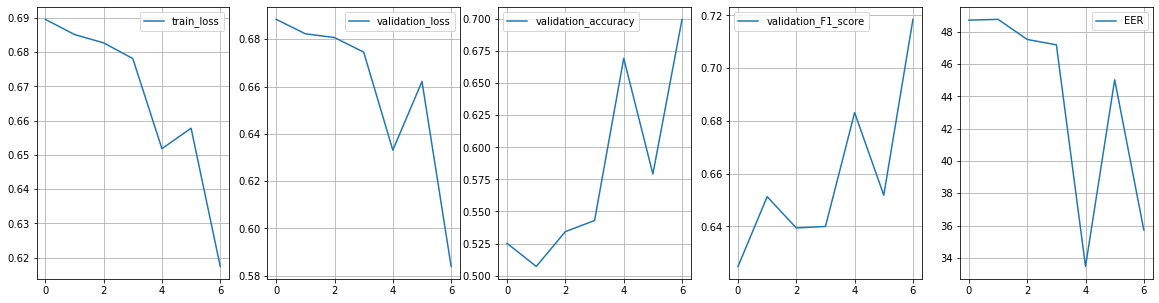

Epoch: 8/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.6997899856635375 ---> 0.7367083011733454 !
Confusion Matrix of all:[[3013 1472]
 [ 910 3652]]
minDCF : 1.7276445230463136% 
EER : 27.53623188409232%


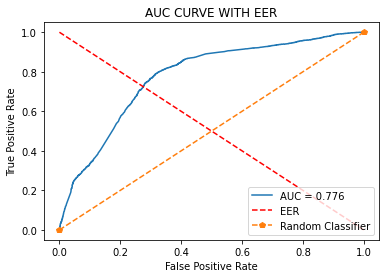

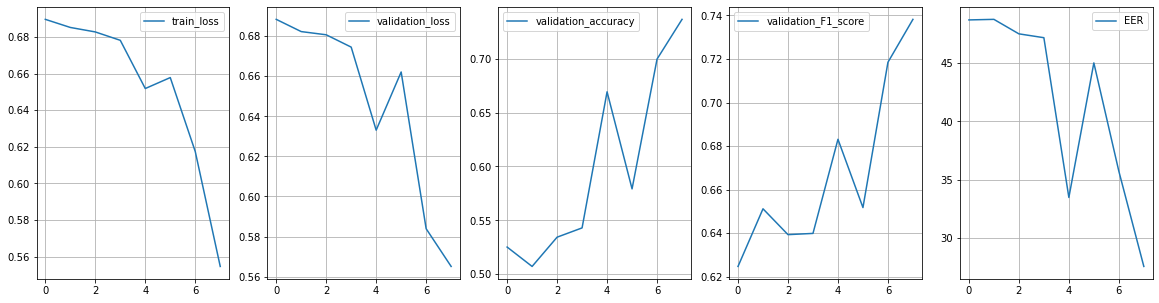

Epoch: 9/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.7367083011733454 ---> 0.7446667403888607 !
Confusion Matrix of all:[[2885 1600]
 [ 710 3852]]
minDCF : 1.847021111970819% 
EER : 26.870785895877088%


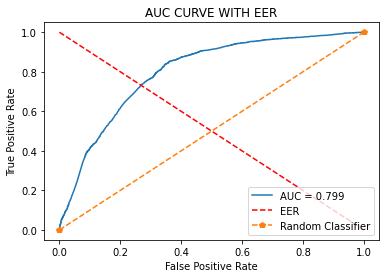

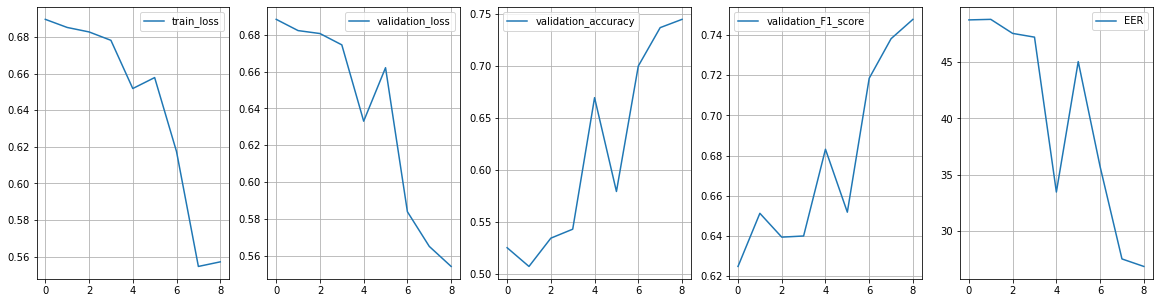

Epoch: 10/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.7446667403888607 ---> 0.7653365757394999 !
Confusion Matrix of all:[[2837 1648]
 [ 475 4087]]
minDCF : 1.8741019122361005% 
EER : 28.02895564583971%


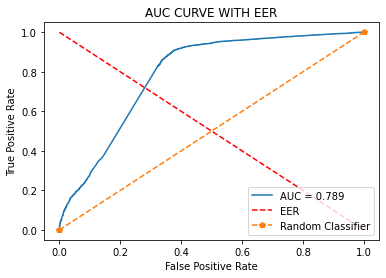

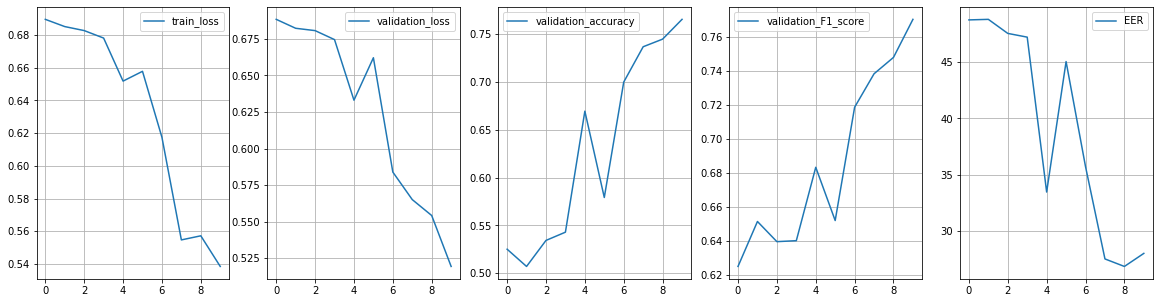

Epoch: 11/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.7653365757394999 ---> 0.7726318117556842 !
Confusion Matrix of all:[[2762 1723]
 [ 334 4228]]
minDCF : 1.9414170443240855% 
EER : 26.668316780396278%


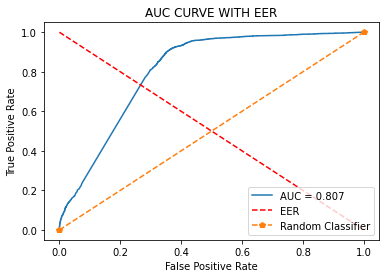

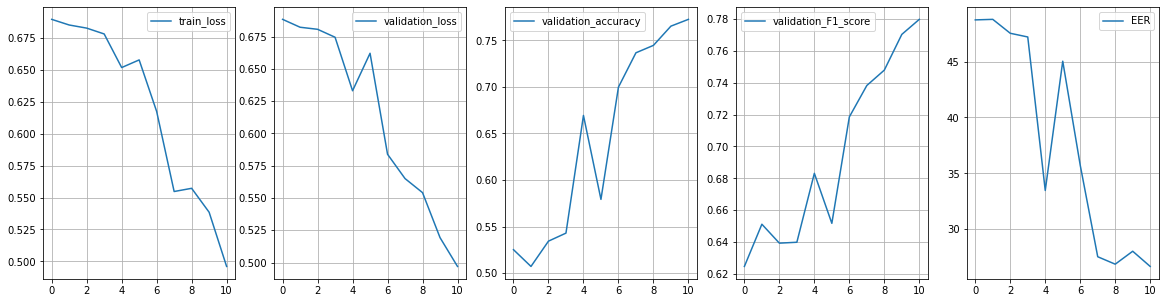

Epoch: 12/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.7726318117556842 ---> 0.786448546459731 !
Confusion Matrix of all:[[2851 1634]
 [ 298 4264]]
minDCF : 1.8390626727091857% 
EER : 24.9052396878619%


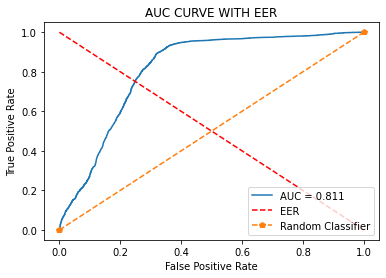

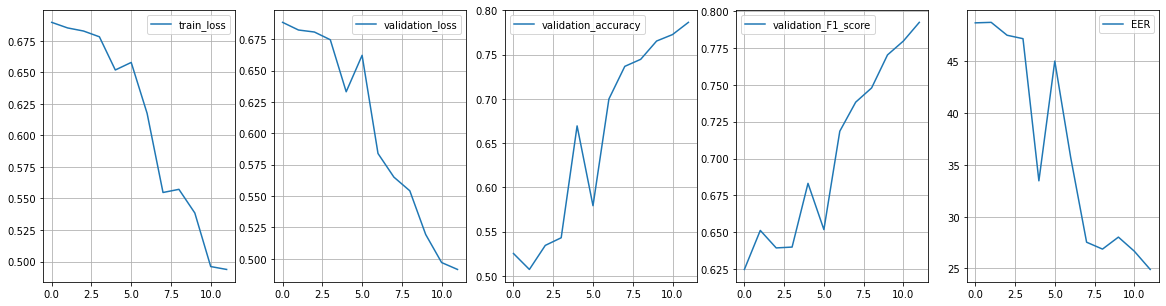

Epoch: 13/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.786448546459731 ---> 0.7899856307011909 !
Confusion Matrix of all:[[2939 1546]
 [ 354 4208]]
minDCF : 1.7479827567149335% 
EER : 24.169453734519813%


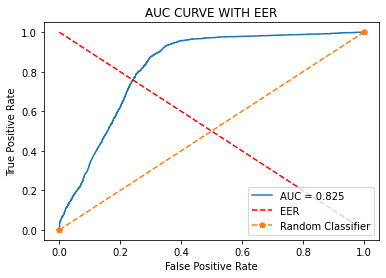

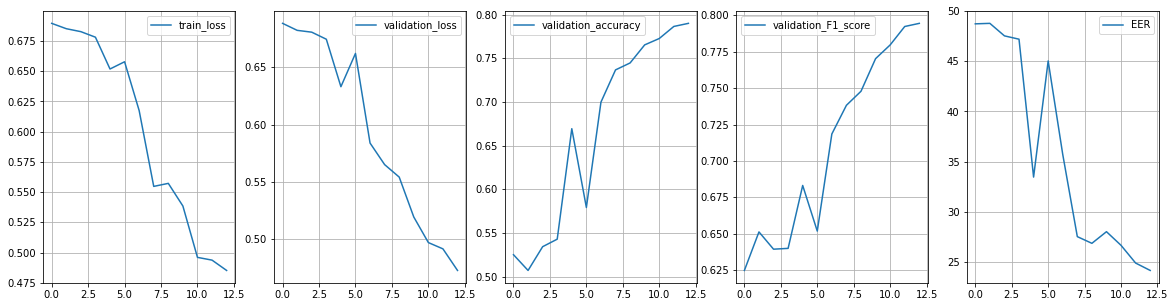

Epoch: 14/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.7899856307011909 ---> 0.7956228584851615 !
Confusion Matrix of all:[[3356 1129]
 [ 720 3842]]
minDCF : 1.3275118823919532% 
EER : 21.7837235227694%


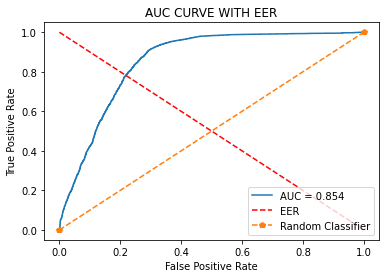

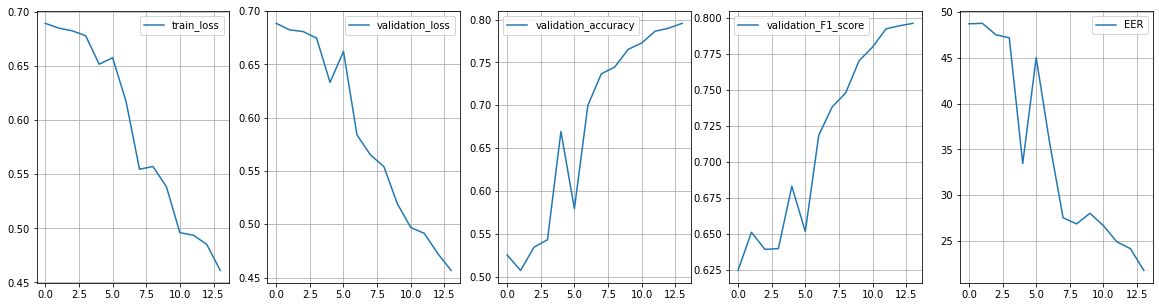

Epoch: 15/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[2827 1658]
 [ 266 4296]]
minDCF : 1.8620537194650164% 
EER : 22.02898550718405%


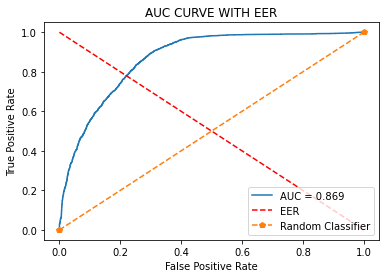

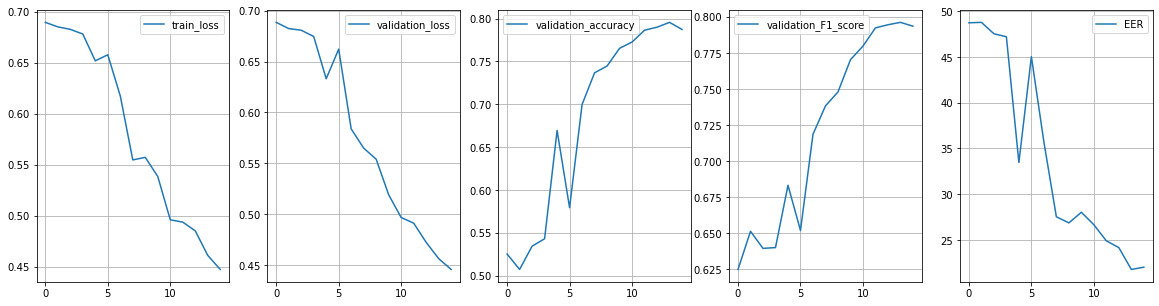

Epoch: 16/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.7956228584851615 ---> 0.8092185255834723 !
Confusion Matrix of all:[[3476 1009]
 [ 717 3845]]
minDCF : 1.1945396263954902% 
EER : 20.0350723366944%


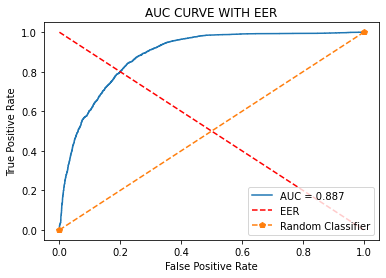

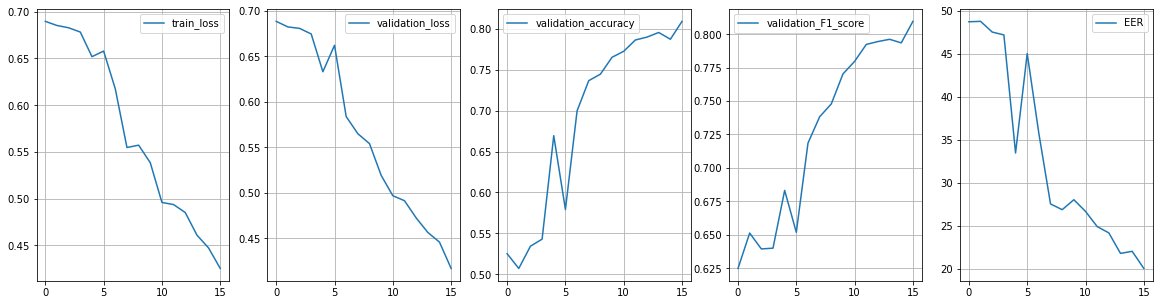

Epoch: 17/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[3897  588]
 [1175 3387]]
minDCF : 0.7798165137614679% 
EER : 17.56967670004212%


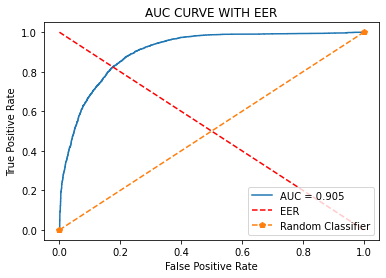

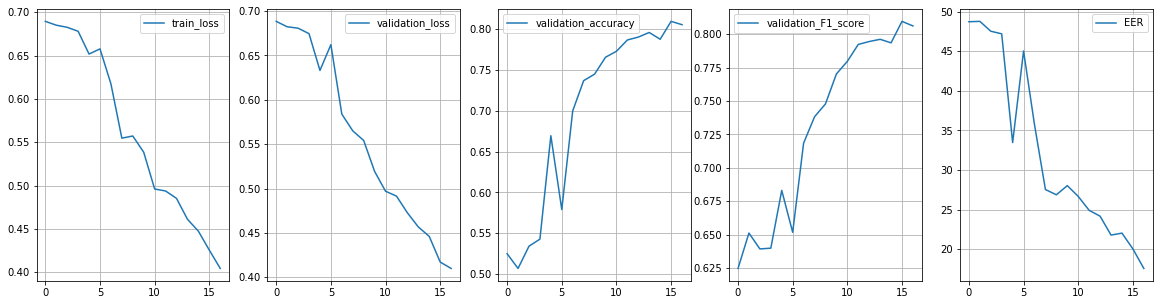

Epoch: 18/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8092185255834723 ---> 0.8514424672215845 !
Confusion Matrix of all:[[3745  740]
 [ 604 3958]]
minDCF : 0.8847131645849453% 
EER : 15.146865409878801%


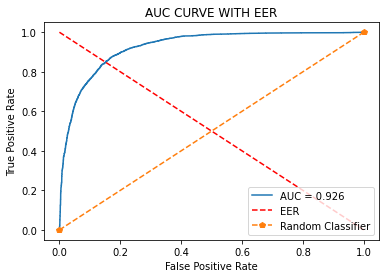

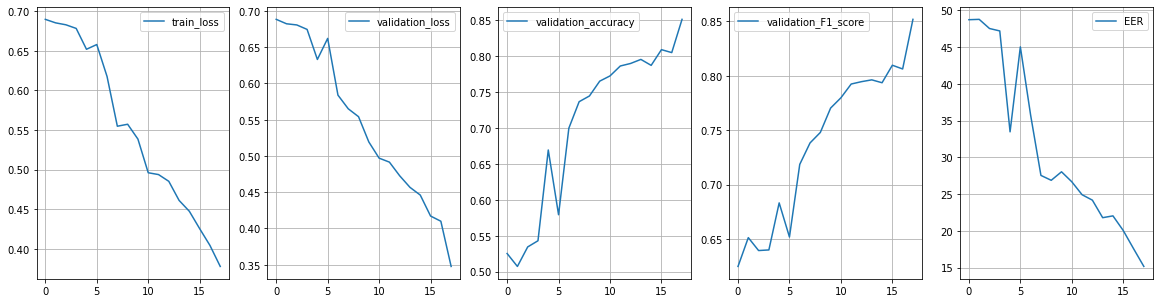

Epoch: 19/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4085  400]
 [1090 3472]]
minDCF : 0.5626174422460485% 
EER : 14.68654099079366%


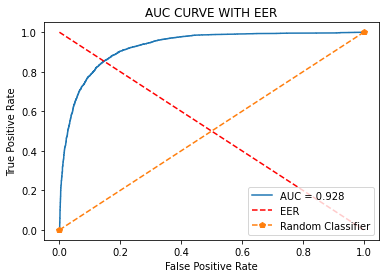

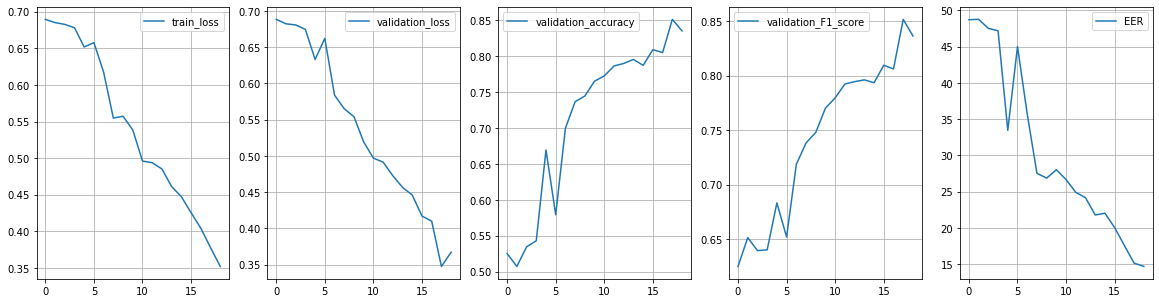

Epoch: 20/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8514424672215845 ---> 0.8581850338182463 !
Confusion Matrix of all:[[3825  660]
 [ 623 3939]]
minDCF : 0.7983862053719466% 
EER : 14.292084726804017%


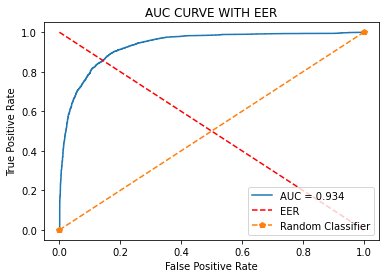

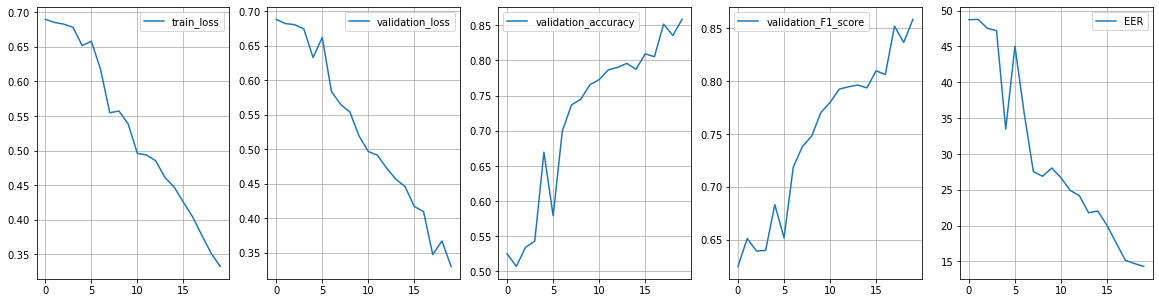

Epoch: 21/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8581850338182463 ---> 0.8658118714176253 !
Confusion Matrix of all:[[3720  765]
 [ 449 4113]]
minDCF : 0.8952138830551565% 
EER : 13.22185061305006%


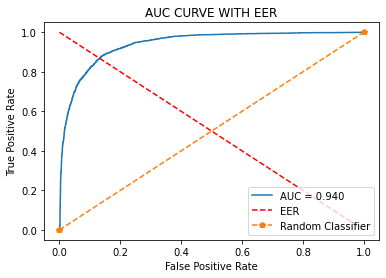

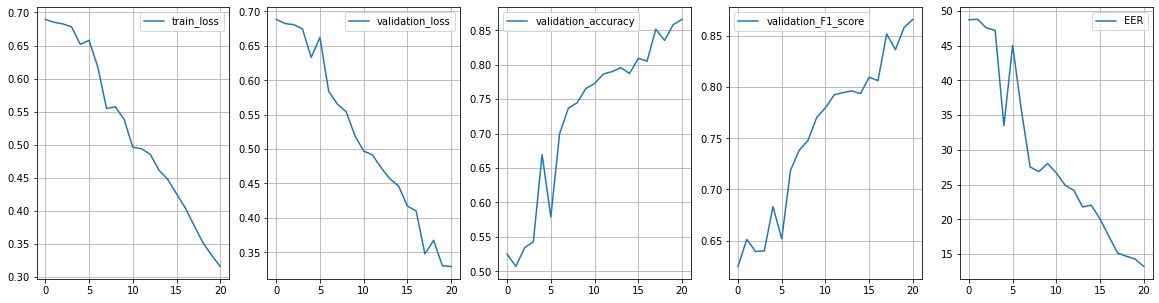

Epoch: 22/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8658118714176253 ---> 0.8717807008111439 !
Confusion Matrix of all:[[4040  445]
 [ 715 3847]]
minDCF : 0.5709074831435835% 
EER : 12.619843924281232%


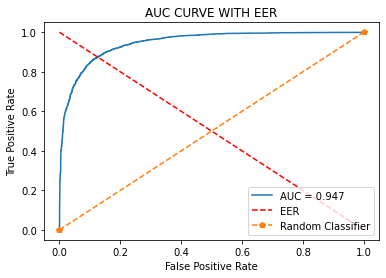

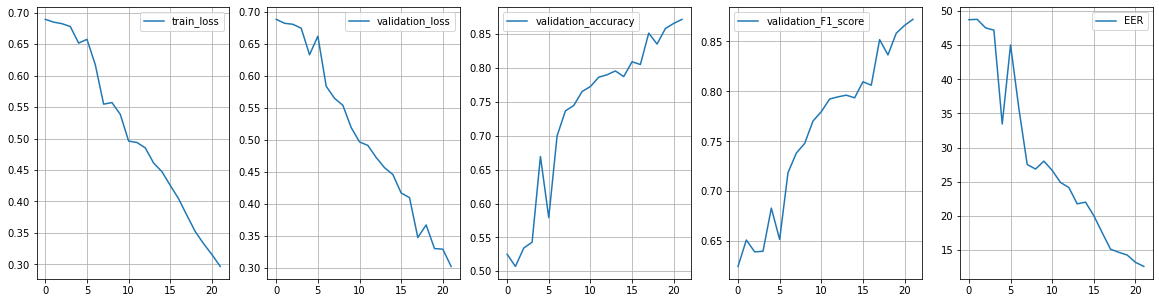

Epoch: 23/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8717807008111439 ---> 0.8744335139247085 !
Confusion Matrix of all:[[3835  650]
 [ 486 4076]]
minDCF : 0.7721896761357356% 
EER : 12.419175027974951%


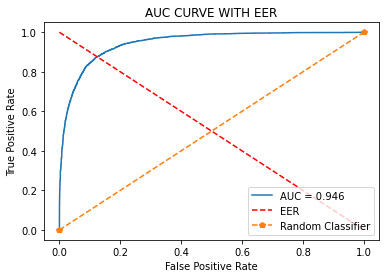

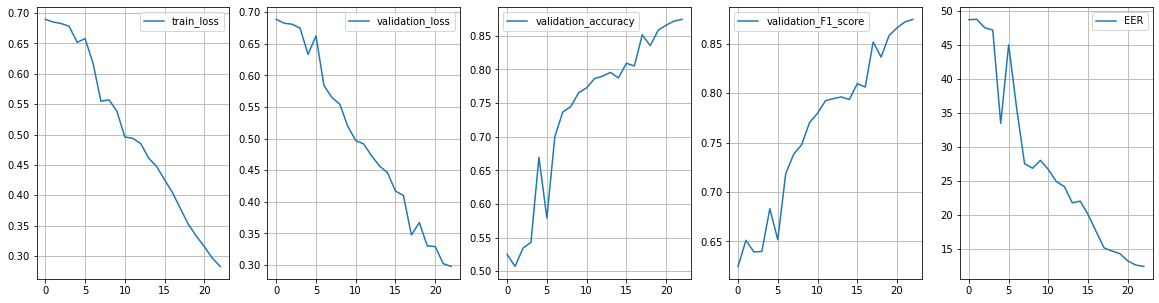

Epoch: 24/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8744335139247085 ---> 0.8791864707586685 !
Confusion Matrix of all:[[3987  498]
 [ 595 3967]]
minDCF : 0.6162263733834421% 
EER : 12.21850613158729%


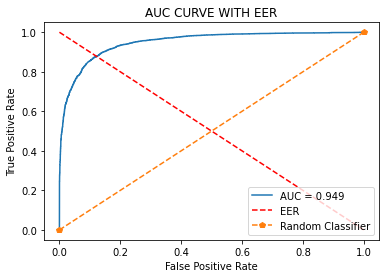

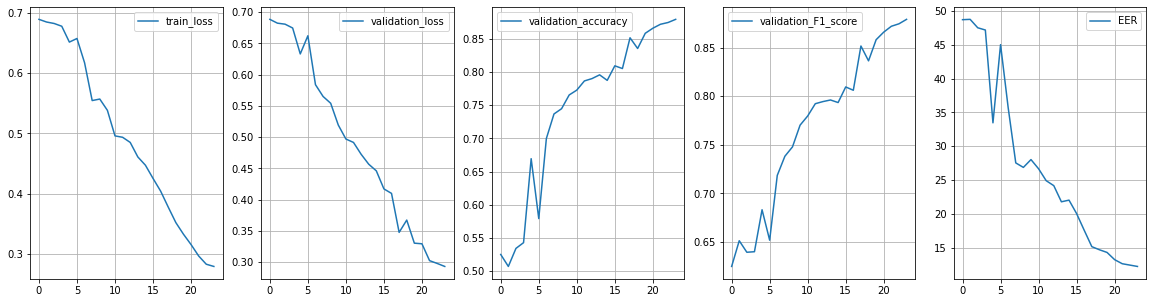

Epoch: 25/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8791864707586685 ---> 0.8816182160622589 !
Confusion Matrix of all:[[4152  333]
 [ 738 3824]]
minDCF : 0.4496518182823036% 
EER : 11.237458194030966%


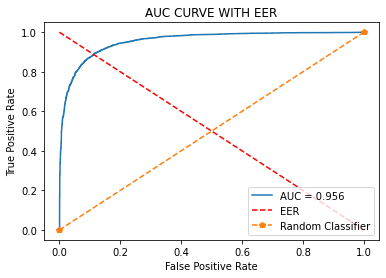

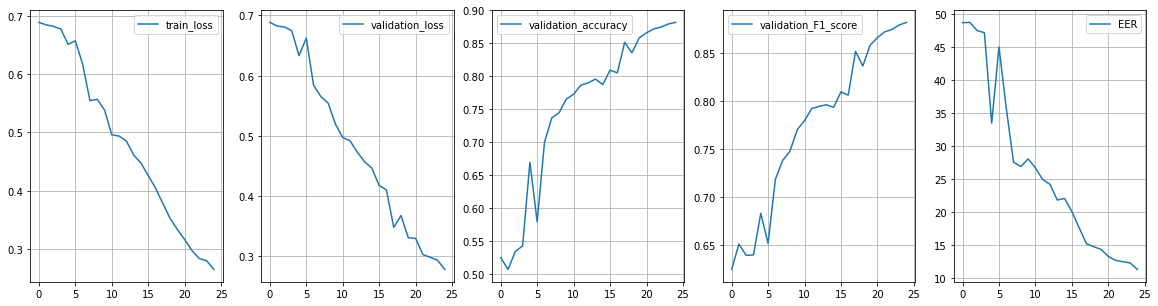

Epoch: 26/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8816182160622589 ---> 0.8899082569334406 !
Confusion Matrix of all:[[3877  608]
 [ 388 4174]]
minDCF : 0.7149331270034266% 
EER : 10.740903112671166%


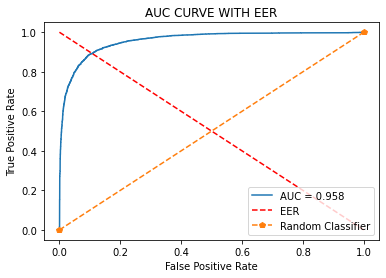

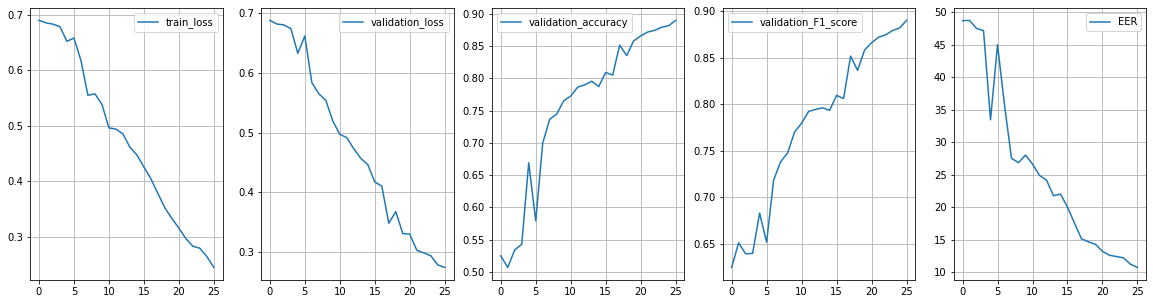

Epoch: 27/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.8899082569334406 ---> 0.9014037803377093 !
Confusion Matrix of all:[[4069  416]
 [ 476 4086]]
minDCF : 0.5124350613463027% 
EER : 9.886014905742053%


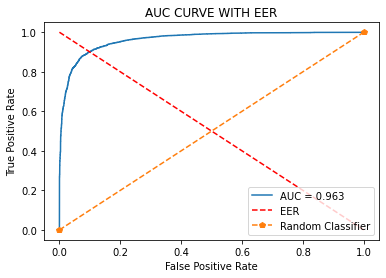

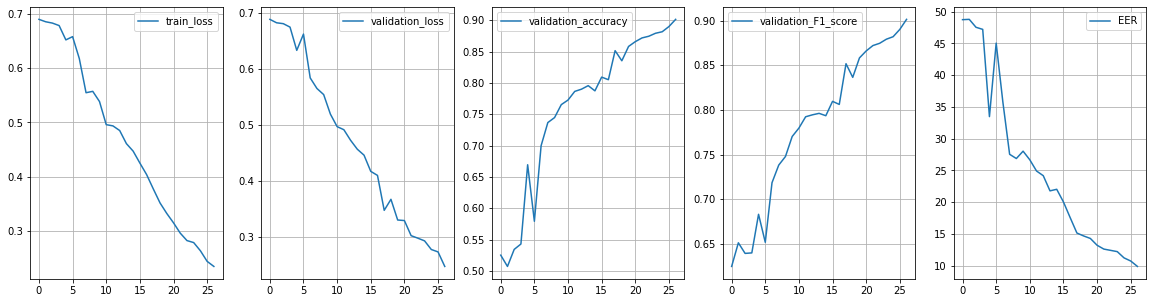

Epoch: 28/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9014037803377093 ---> 0.9067094064857784 !
Confusion Matrix of all:[[4195  290]
 [ 554 4008]]
minDCF : 0.38178401680114954% 
EER : 9.275362318843191%


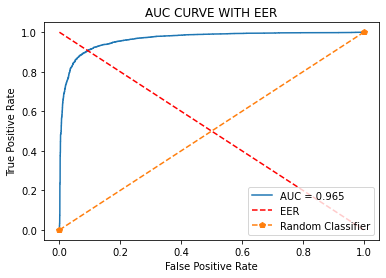

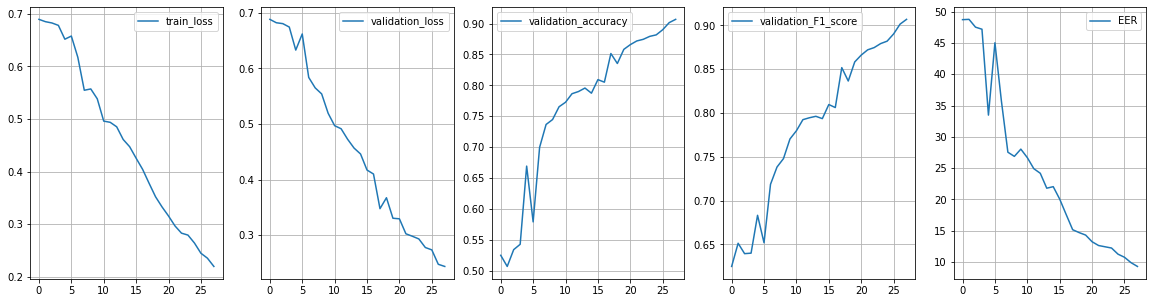

Epoch: 29/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4140  345]
 [ 519 4043]]
minDCF : 0.43870896429755724% 
EER : 9.579131959703249%


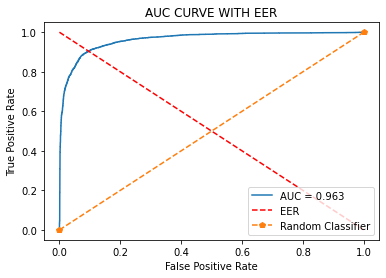

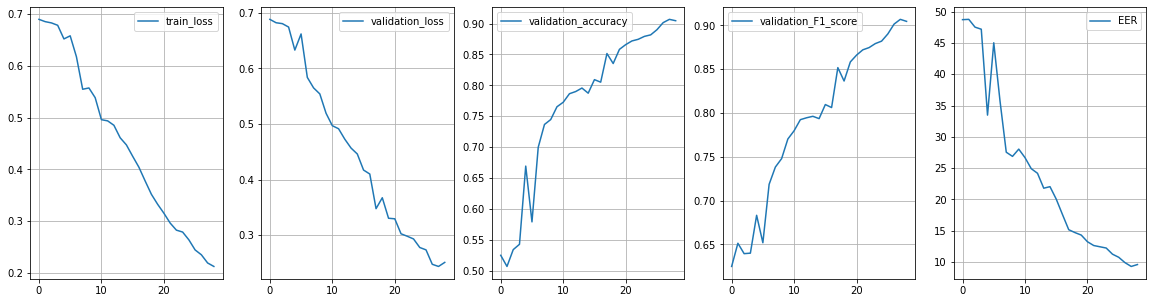

Epoch: 30/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[3973  512]
 [ 352 4210]]
minDCF : 0.6048413838841605% 
EER : 9.386845039105692%


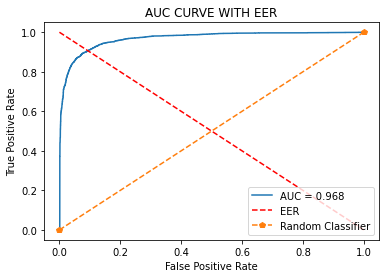

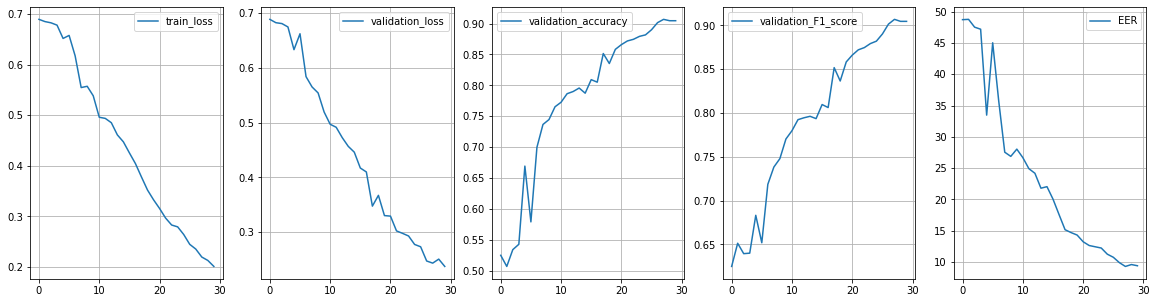

Epoch: 31/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9067094064857784 ---> 0.9101359566970729 !
Confusion Matrix of all:[[4170  315]
 [ 498 4064]]
minDCF : 0.403227589256107% 
EER : 8.940914158206976%


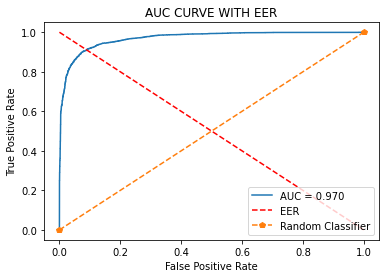

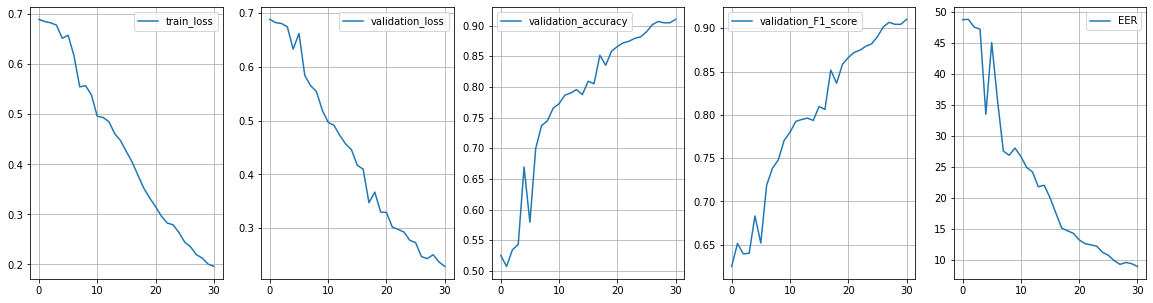

Epoch: 32/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9101359566970729 ---> 0.9125677020270165 !
Confusion Matrix of all:[[4213  272]
 [ 519 4043]]
minDCF : 0.35801923289488236% 
EER : 8.584169453702122%


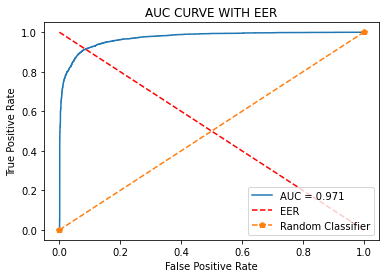

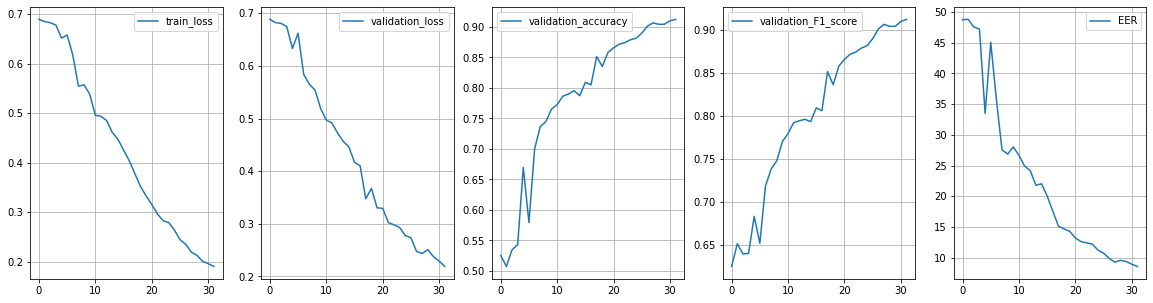

Epoch: 33/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9125677020270165 ---> 0.9154415828978487 !
Confusion Matrix of all:[[4222  263]
 [ 502 4060]]
minDCF : 0.3461921078810656% 
EER : 8.316610925342207%


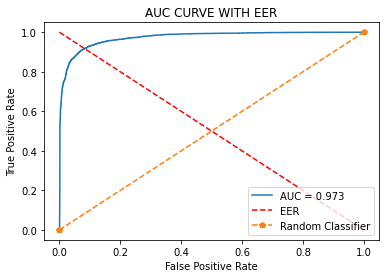

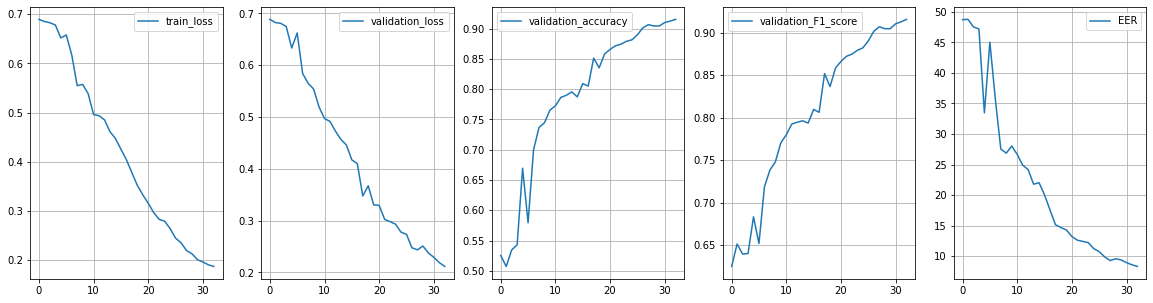

Epoch: 34/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4253  232]
 [ 563 3999]]
minDCF : 0.318669172101249% 
EER : 8.483121437965972%


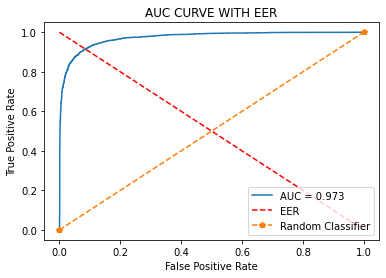

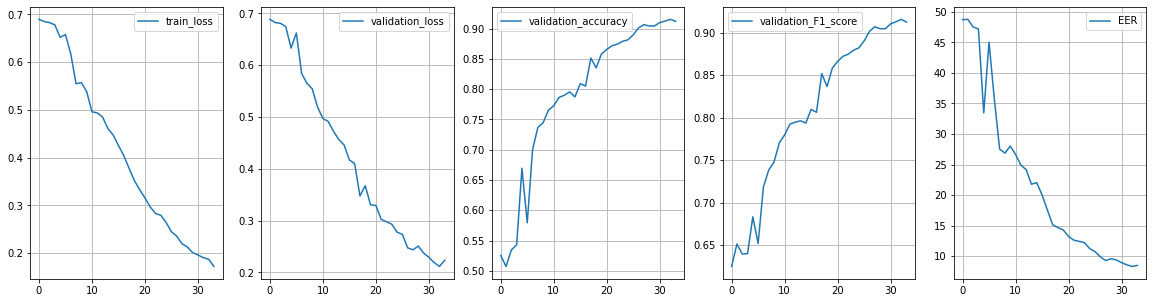

Epoch: 35/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[3927  558]
 [ 293 4269]]
minDCF : 0.6491654692163148% 
EER : 9.230769230812912%


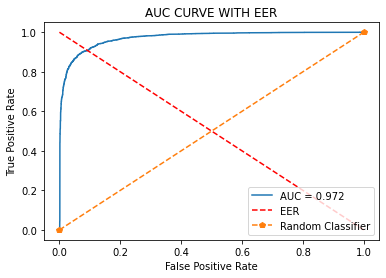

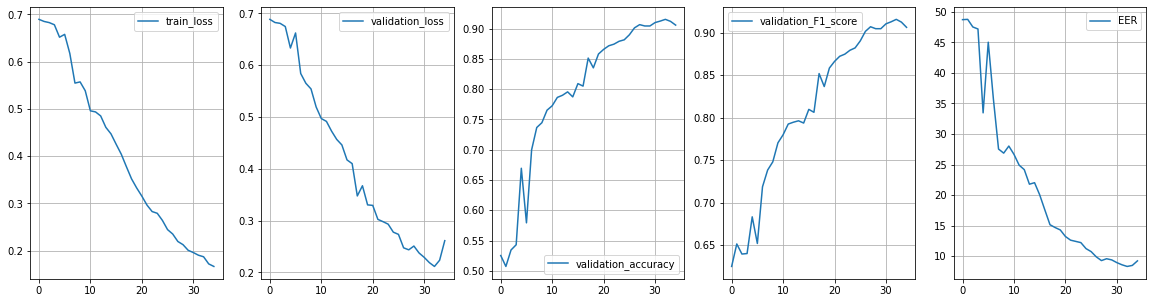

Epoch: 36/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9154415828978487 ---> 0.9195313364072993 !
Confusion Matrix of all:[[4255  230]
 [ 498 4064]]
minDCF : 0.30927379241737596% 
EER : 7.84743533537922%


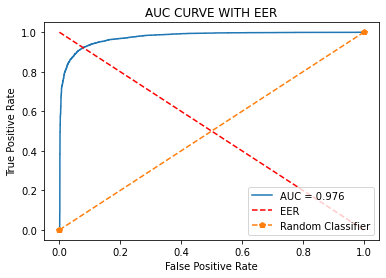

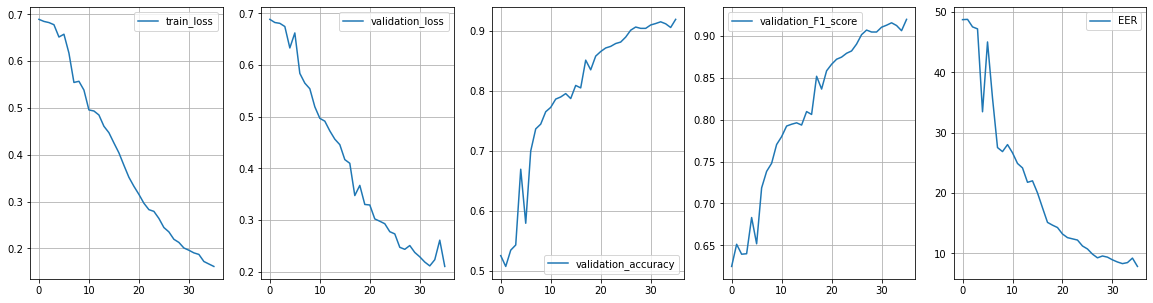

Epoch: 37/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9195313364072993 ---> 0.9261633690726208 !
Confusion Matrix of all:[[4232  253]
 [ 415 4147]]
minDCF : 0.3255222725765447% 
EER : 7.058307759754278%


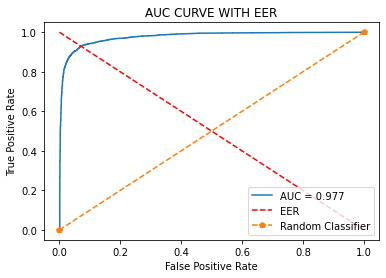

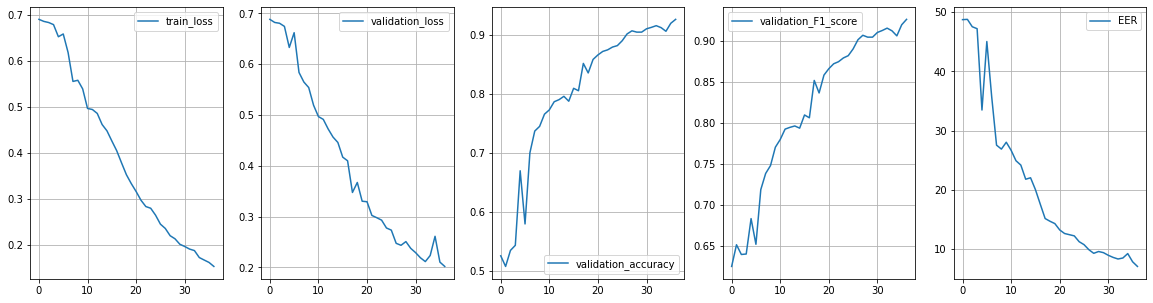

Epoch: 38/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4223  262]
 [ 422 4140]]
minDCF : 0.33624405880402347% 
EER : 7.518632178868927%


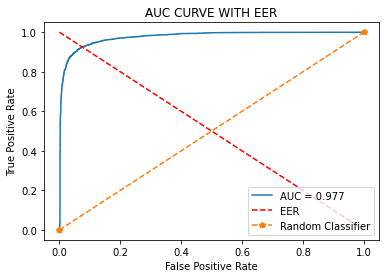

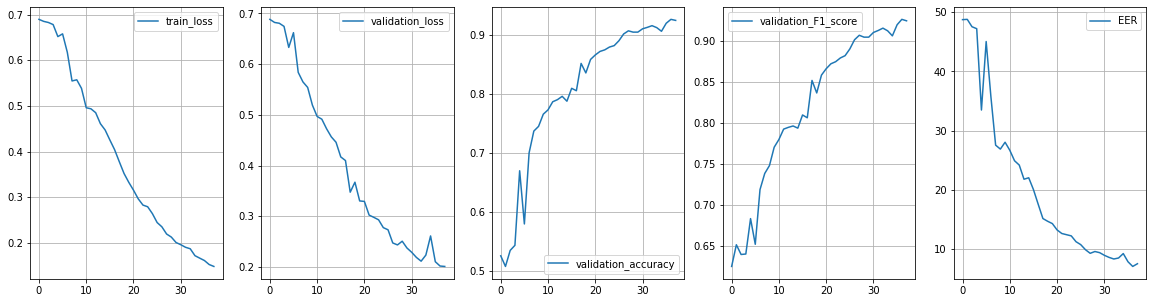

Epoch: 39/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4145  340]
 [ 364 4198]]
minDCF : 0.4160495191776279% 
EER : 7.803594914511175%


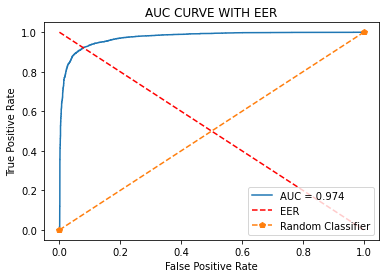

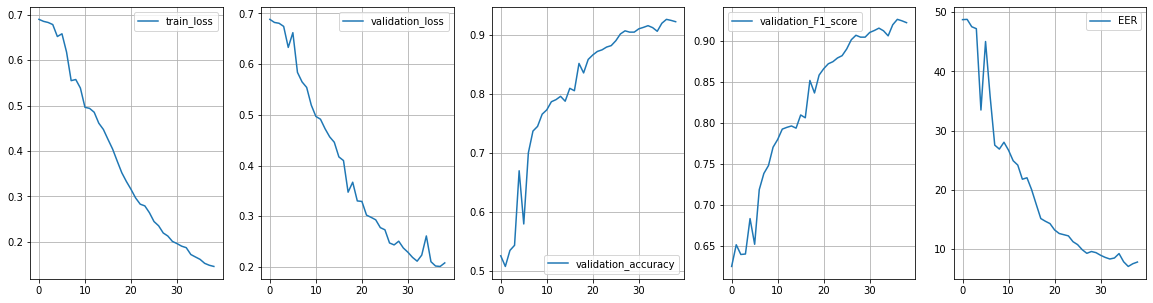

Epoch: 40/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4216  269]
 [ 415 4147]]
minDCF : 0.3432076931579529% 
EER : 7.452871547574122%


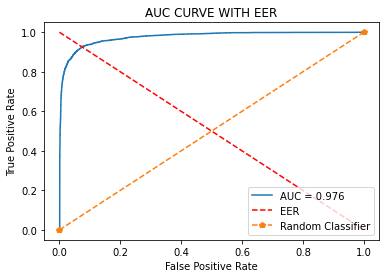

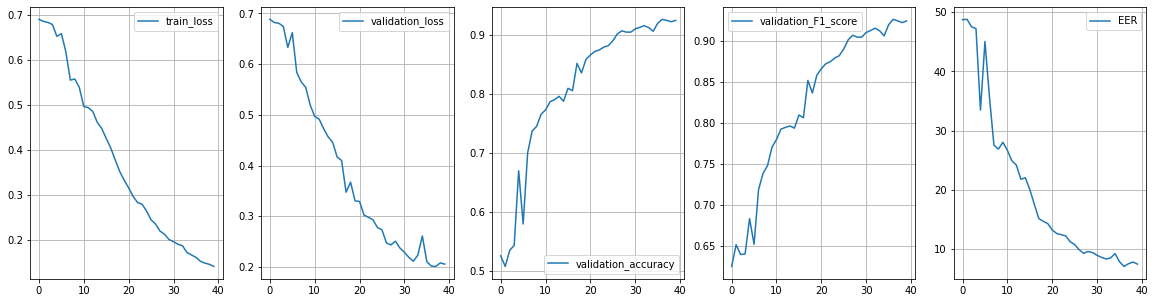

Epoch: 41/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4298  187]
 [ 517 4045]]
minDCF : 0.26384436829888364% 
EER : 7.606313020605425%


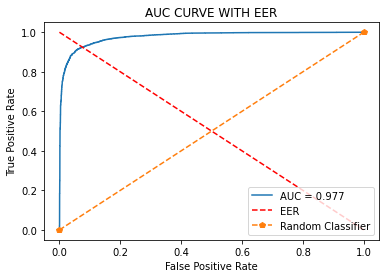

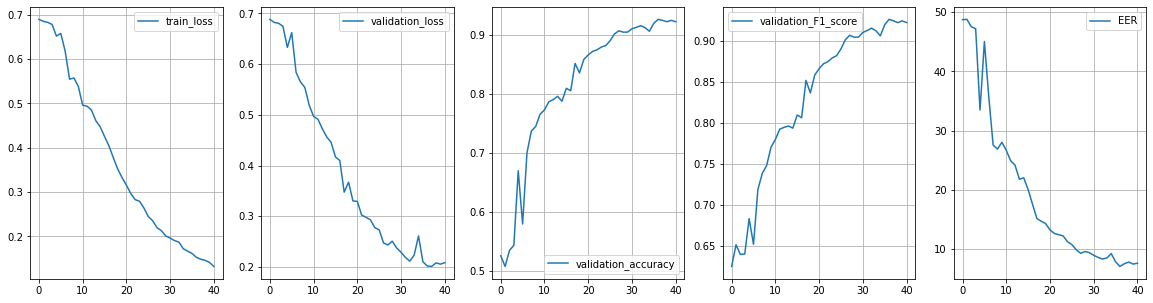

Epoch: 42/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4326  159]
 [ 515 4047]]
minDCF : 0.23267381452415167% 
EER : 6.904866286703217%


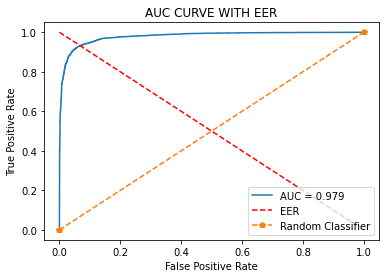

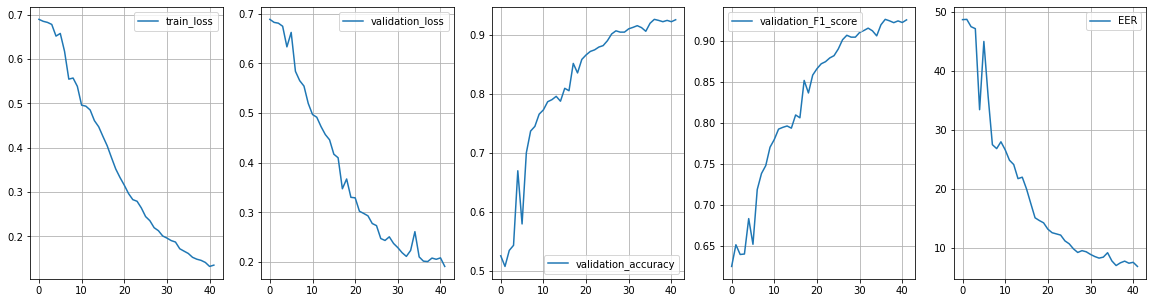

Epoch: 43/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9261633690726208 ---> 0.9300320548511571 !
Confusion Matrix of all:[[4187  298]
 [ 335 4227]]
minDCF : 0.36641980767105115% 
EER : 7.023411371248703%


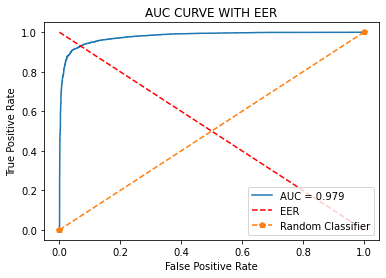

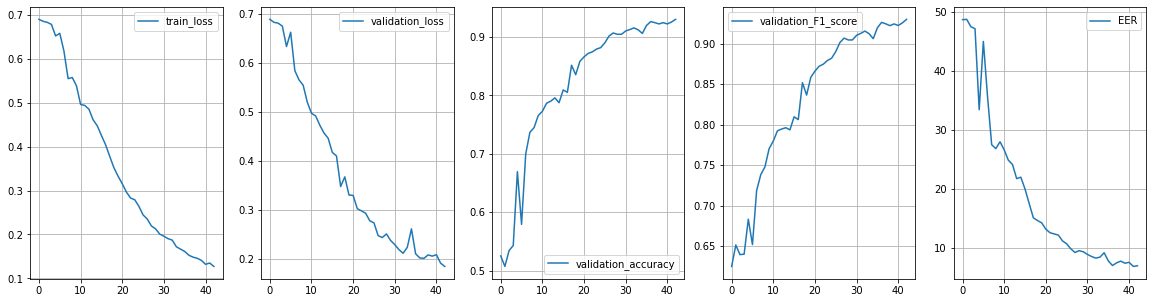

Epoch: 44/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9300320548511571 ---> 0.9372167569623542 !
Confusion Matrix of all:[[4246  239]
 [ 329 4233]]
minDCF : 0.30054161600530566% 
EER : 6.422621657167904%


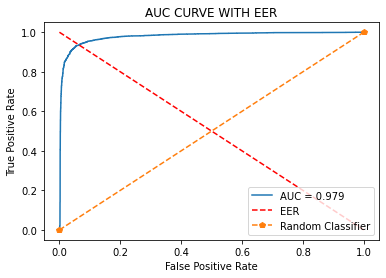

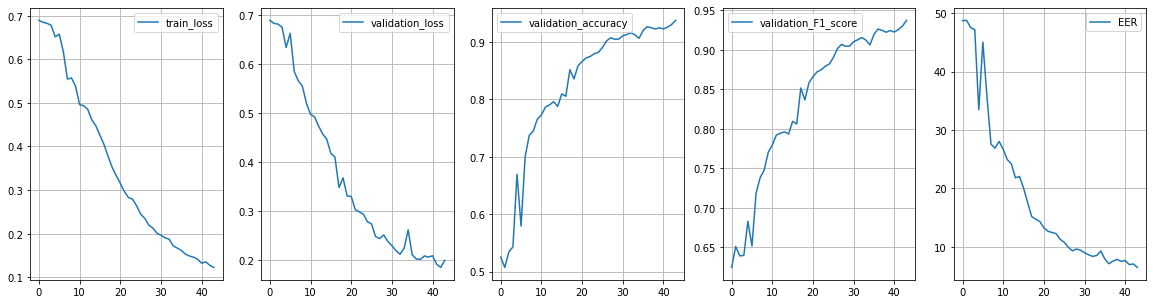

Epoch: 45/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4193  292]
 [ 343 4219]]
minDCF : 0.36067204598209357% 
EER : 7.099619435197561%


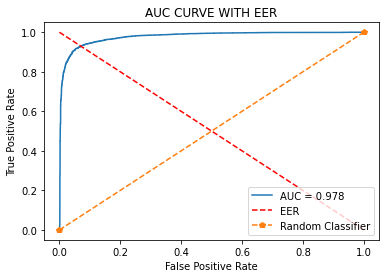

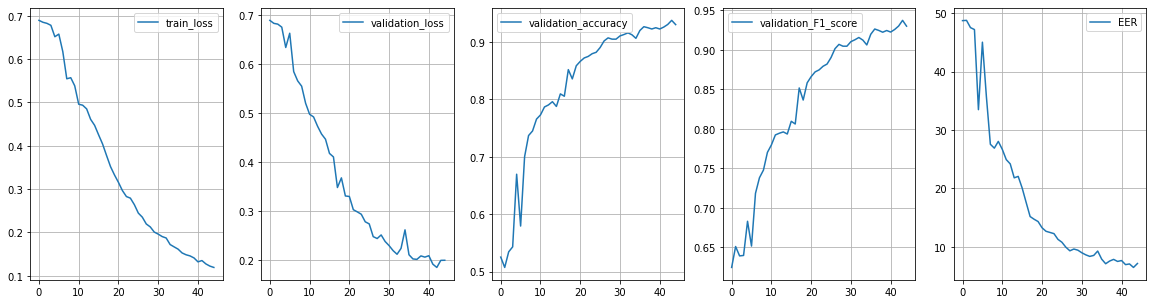

Epoch: 46/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[3892  593]
 [ 225 4337]]
minDCF : 0.6803360229910468% 
EER : 7.869355545812974%


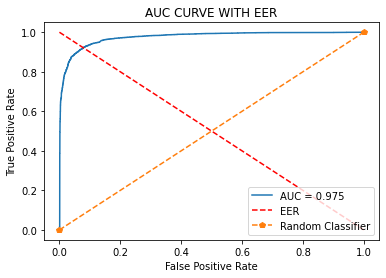

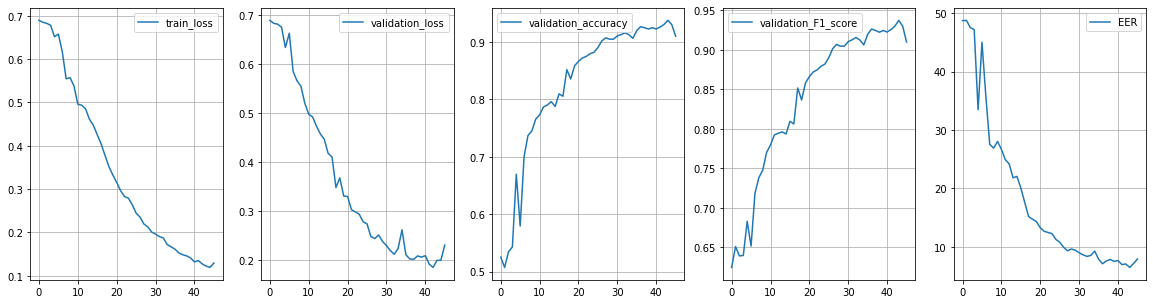

Epoch: 47/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9372167569623542 ---> 0.9381010279914246 !
Confusion Matrix of all:[[4286  199]
 [ 361 4201]]
minDCF : 0.25986514866806676% 
EER : 6.510302498903988%


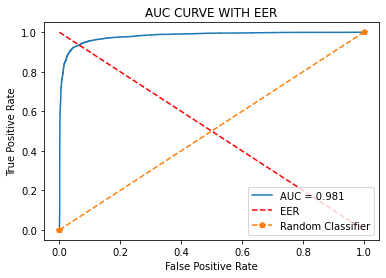

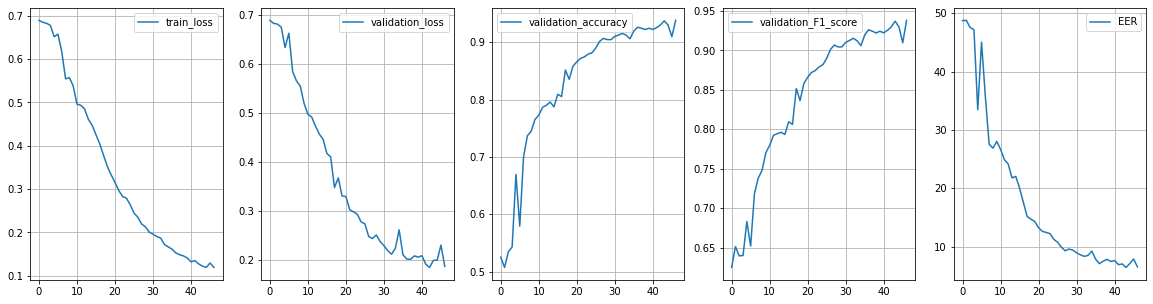

Epoch: 48/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4334  151]
 [ 485 4077]]
minDCF : 0.22051508787443355% 
EER : 7.001114827225111%


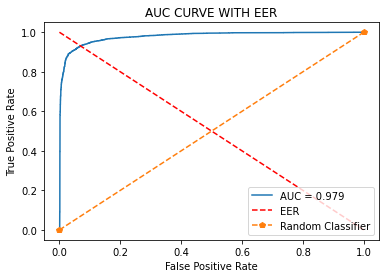

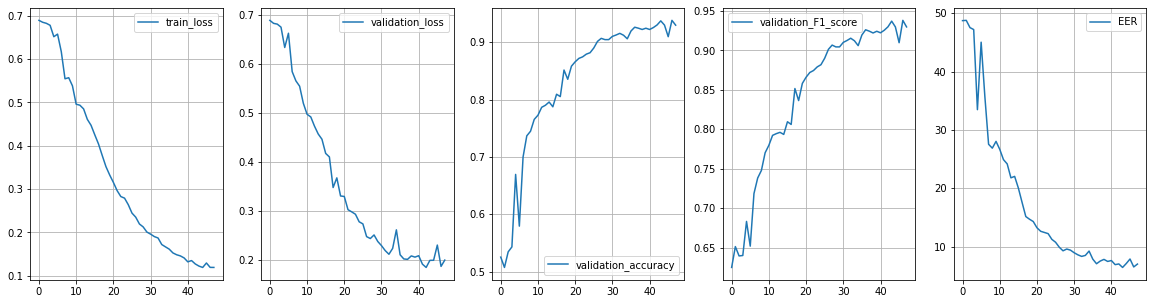

Epoch: 49/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4233  252]
 [ 343 4219]]
minDCF : 0.31645849452857305% 
EER : 6.4882943144362715%


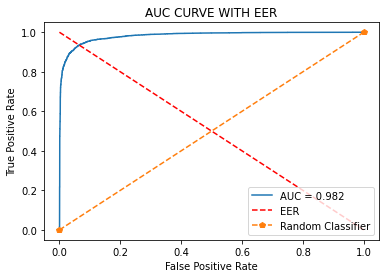

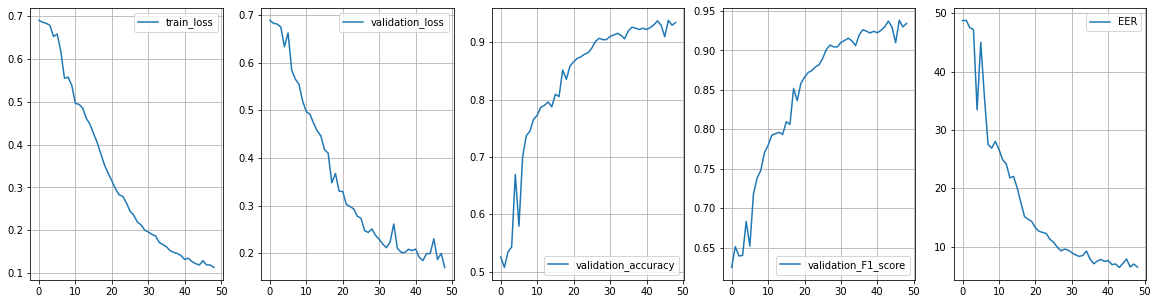

Epoch: 50/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9381010279914246 ---> 0.9407538410522825 !
Confusion Matrix of all:[[4315  170]
 [ 366 4196]]
minDCF : 0.22836299325743342% 
EER : 5.930880713389806%


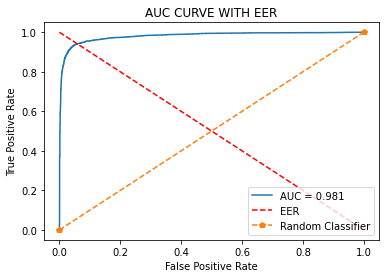

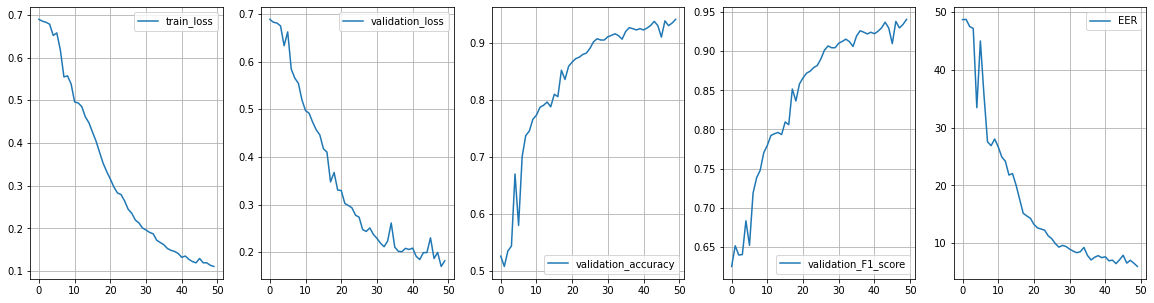

Epoch: 51/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4347  138]
 [ 430 4132]]
minDCF : 0.20006632032718027% 
EER : 6.376811594172898%


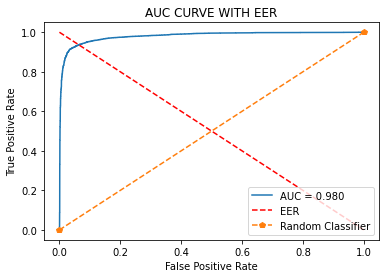

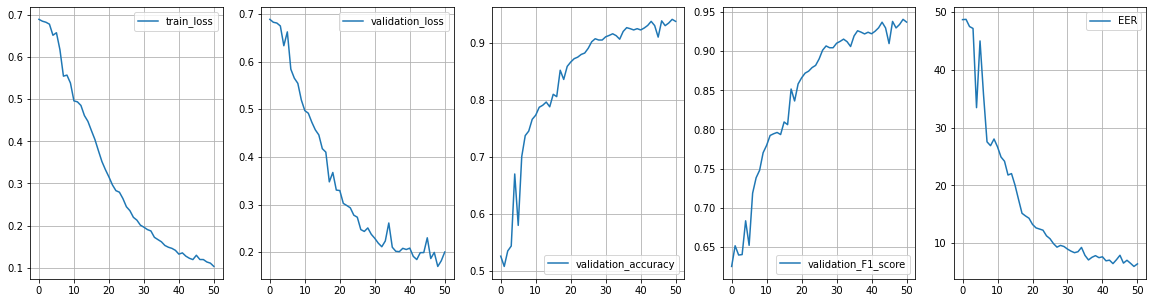

Epoch: 52/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4266  219]
 [ 340 4222]]
minDCF : 0.27965071294351723% 
EER : 6.115738711091616%


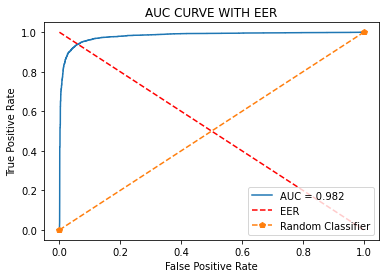

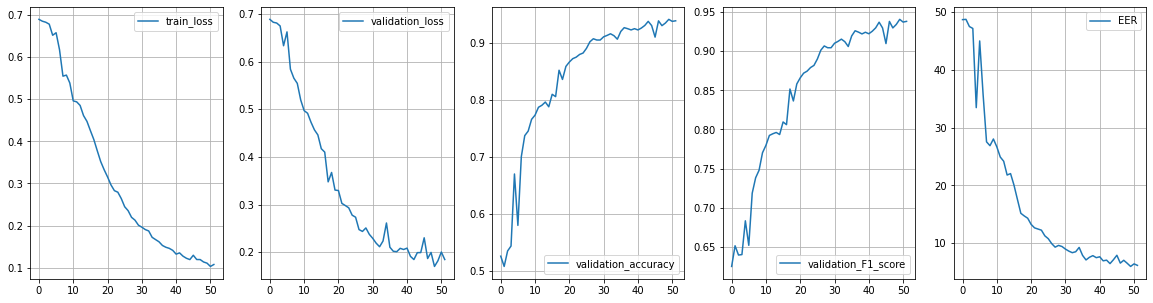

Epoch: 53/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9407538410522825 ---> 0.9409749088095501 !
Confusion Matrix of all:[[4254  231]
 [ 303 4259]]
minDCF : 0.2888250248701227% 
EER : 5.8397670851854455%


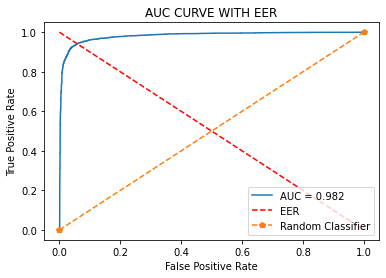

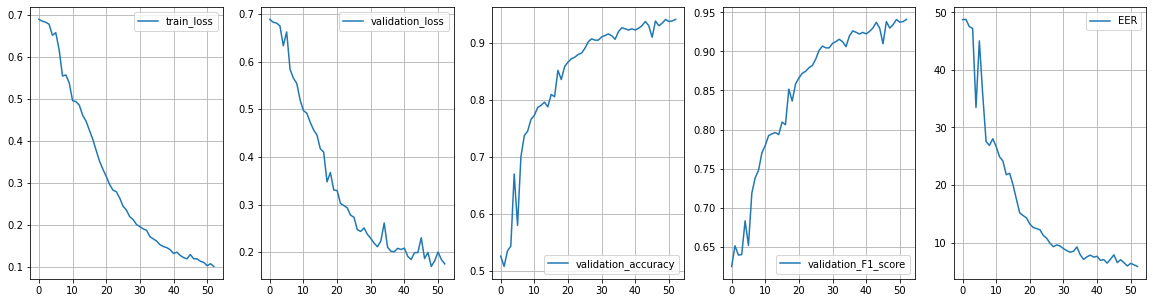

Epoch: 54/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9409749088095501 ---> 0.9448435945617332 !
Confusion Matrix of all:[[4283  202]
 [ 297 4265]]
minDCF : 0.25610699679451754% 
EER : 5.633494081543183%


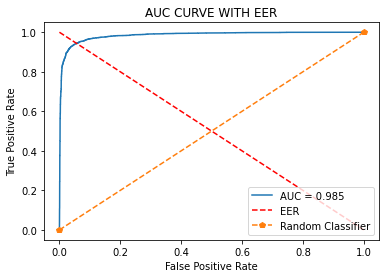

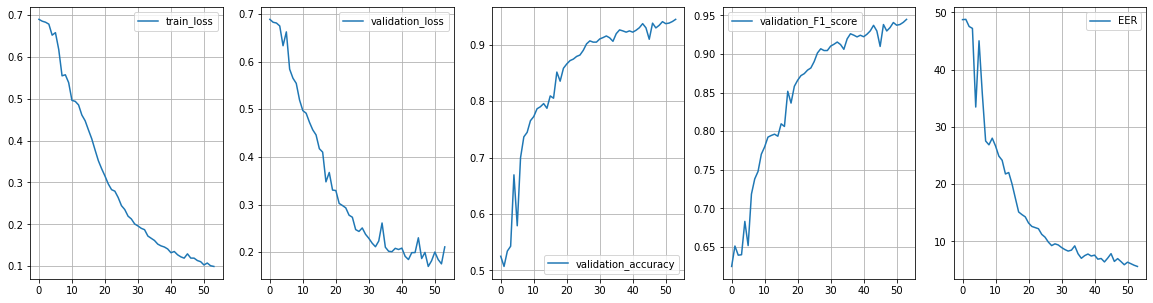

Epoch: 55/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4310  175]
 [ 378 4184]]
minDCF : 0.23521609373272906% 
EER : 6.220735785887179%


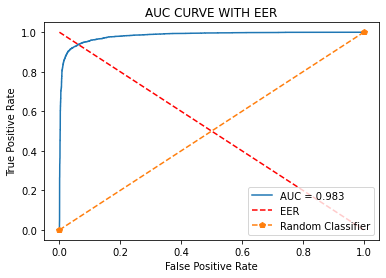

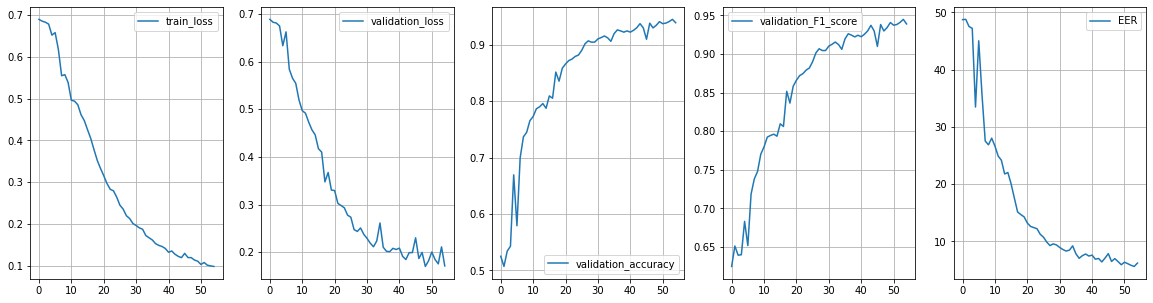

Epoch: 56/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4244  241]
 [ 259 4303]]
minDCF : 0.29501492207361557% 
EER : 5.529542920797152%


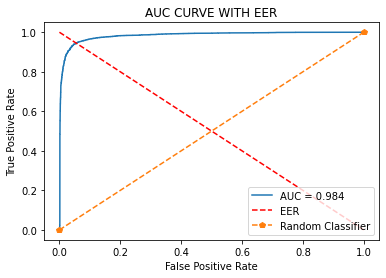

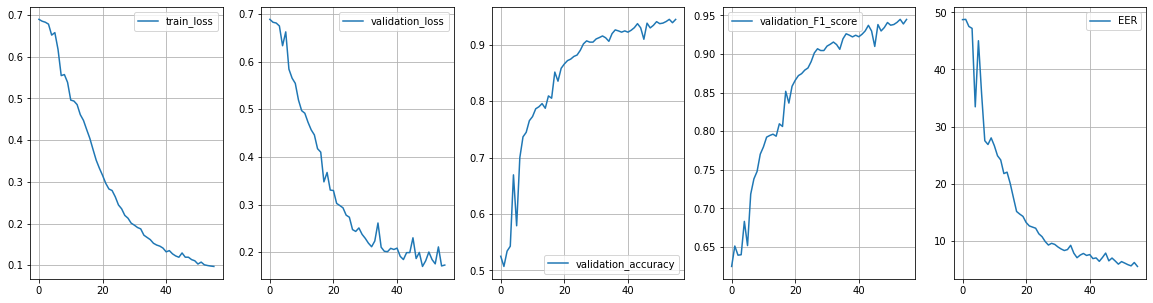

Epoch: 57/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4240  245]
 [ 286 4276]]
minDCF : 0.30242069194208027% 
EER : 5.930880713584327%


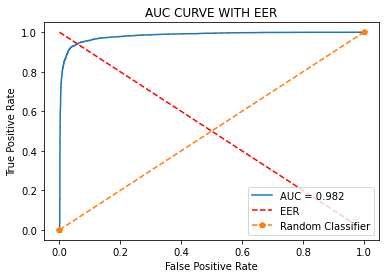

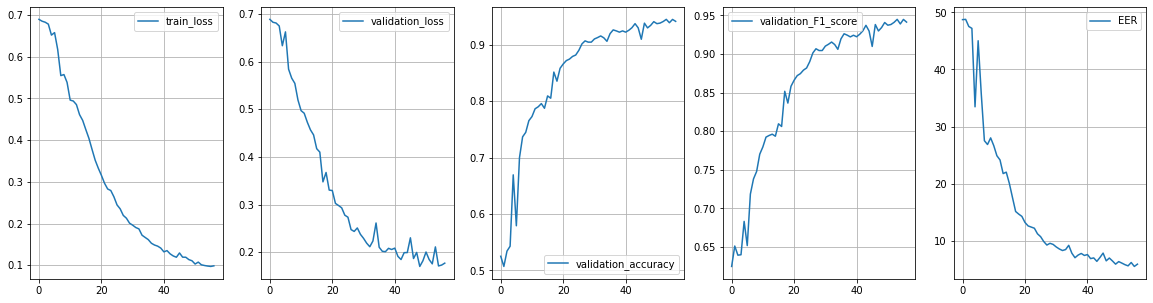

Epoch: 58/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4252  233]
 [ 313 4249]]
minDCF : 0.2921410412291368% 
EER : 5.930880713422289%


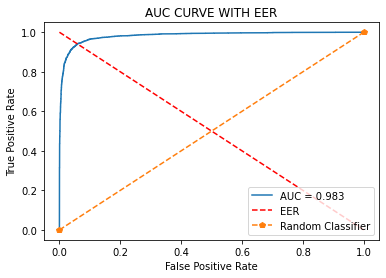

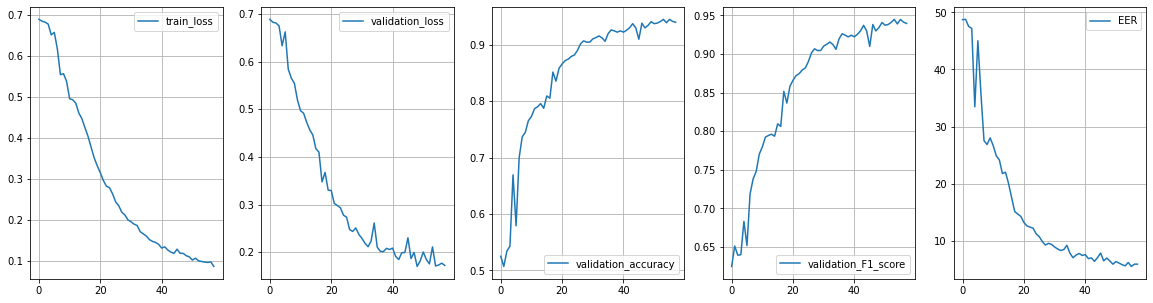

Epoch: 59/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4239  246]
 [ 320 4242]]
minDCF : 0.3072841826019675% 
EER : 6.29229115284892%


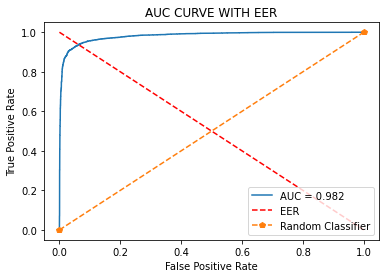

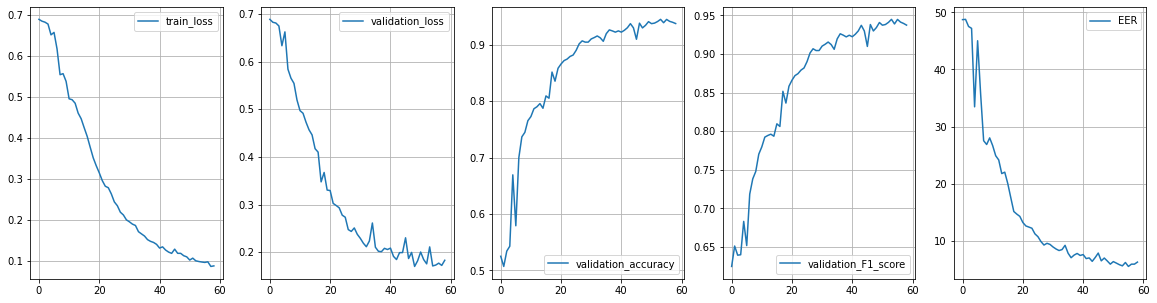

Epoch: 60/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9448435945617332 ---> 0.9455067978598893 !
Confusion Matrix of all:[[4306  179]
 [ 314 4248]]
minDCF : 0.23256328064551784% 
EER : 5.462653288820713%


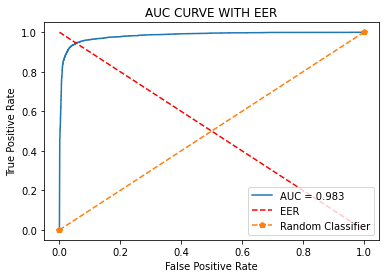

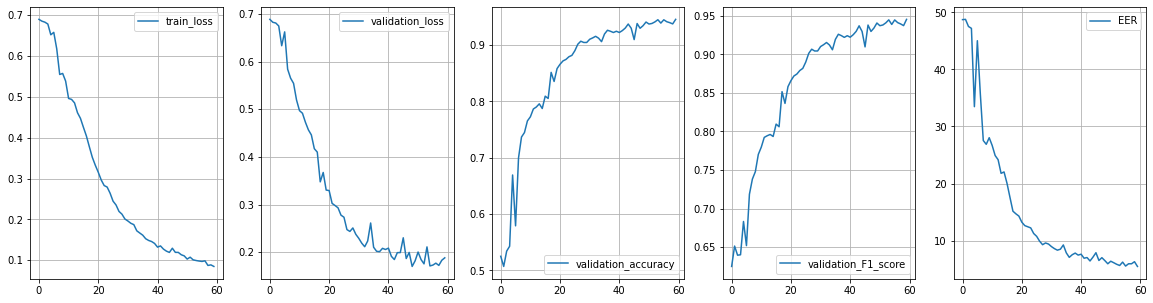

Epoch: 61/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4325  160]
 [ 395 4167]]
minDCF : 0.22051508787443355% 
EER : 5.9184568171867316%


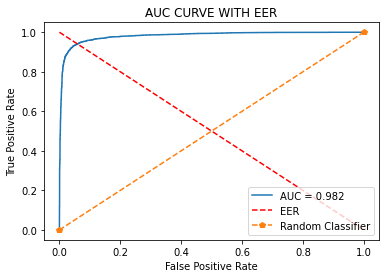

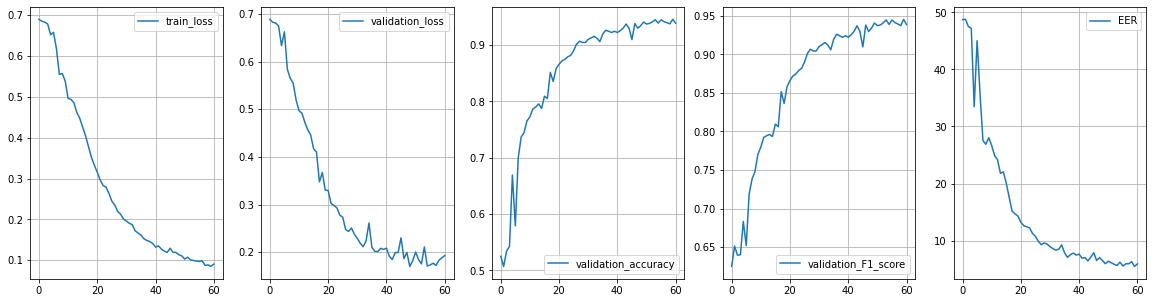

Epoch: 62/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4310  175]
 [ 383 4179]]
minDCF : 0.23576876312589806% 
EER : 6.064659977615788%


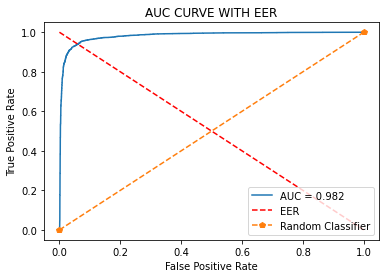

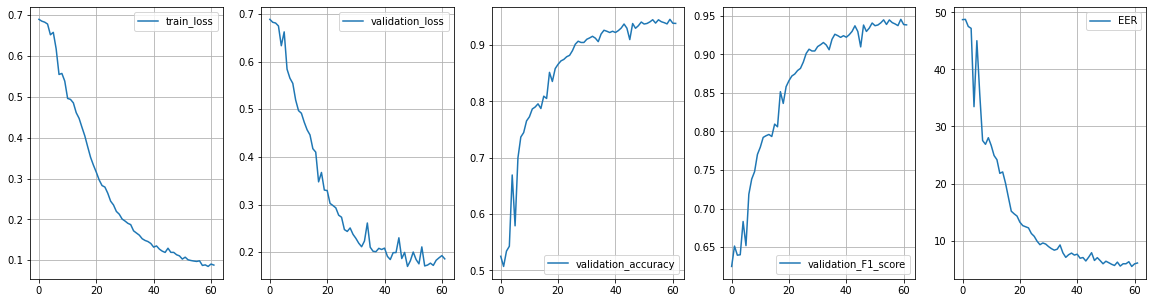

Epoch: 63/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4302  183]
 [ 350 4212]]
minDCF : 0.24096385542168672% 
EER : 5.7869355545469325%


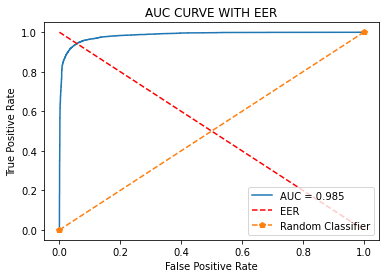

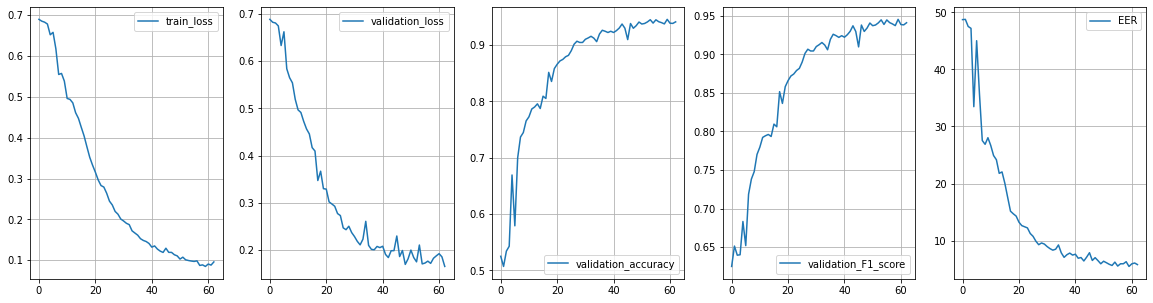

Epoch: 64/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4292  193]
 [ 335 4227]]
minDCF : 0.25035923510555985% 
EER : 5.786935554587369%


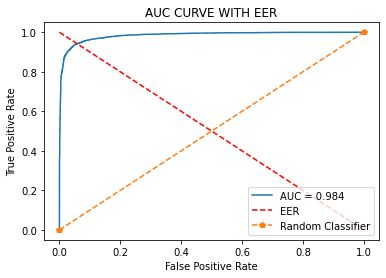

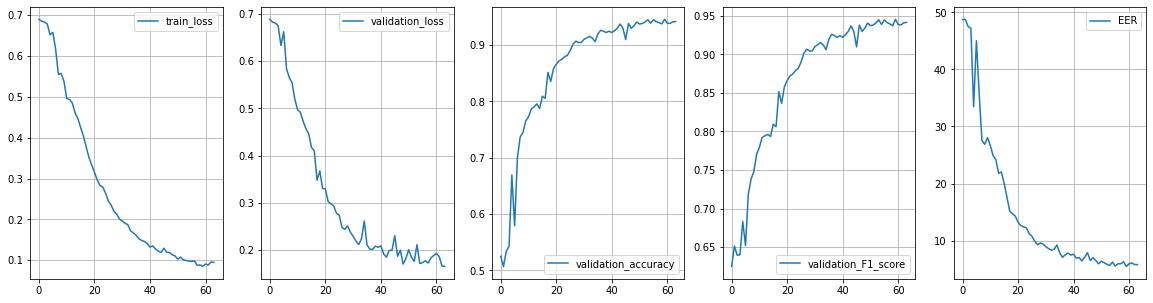

Epoch: 65/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4349  136]
 [ 410 4152]]
minDCF : 0.19564496518182822% 
EER : 5.9622972380641635%


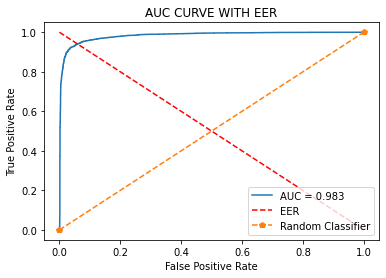

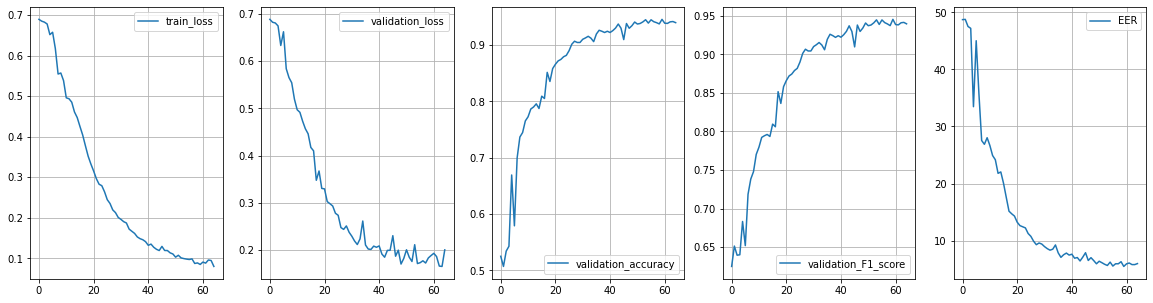

Epoch: 66/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4378  107]
 [ 396 4166]]
minDCF : 0.16204266607715265% 
EER : 5.304690925032877%


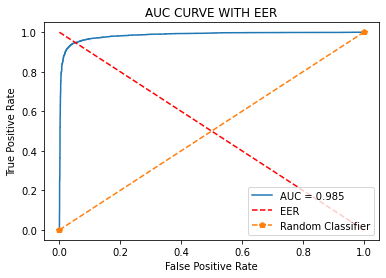

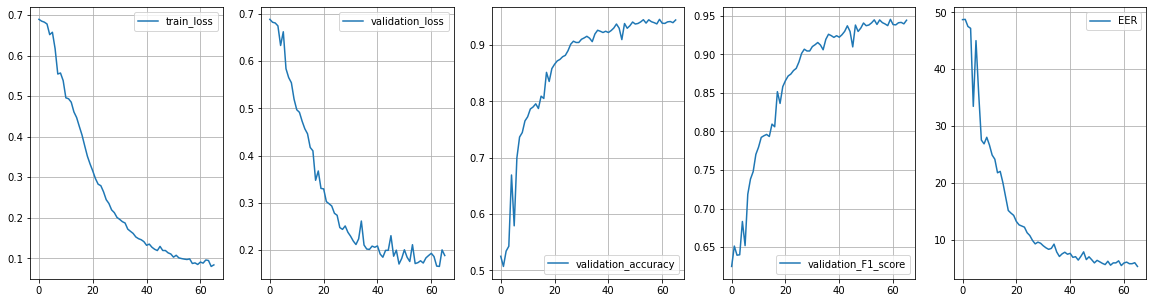

Epoch: 67/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4294  191]
 [ 340 4222]]
minDCF : 0.24870122692605282% 
EER : 5.507246376874952%


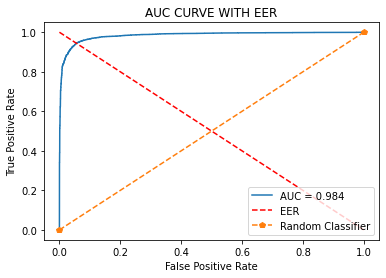

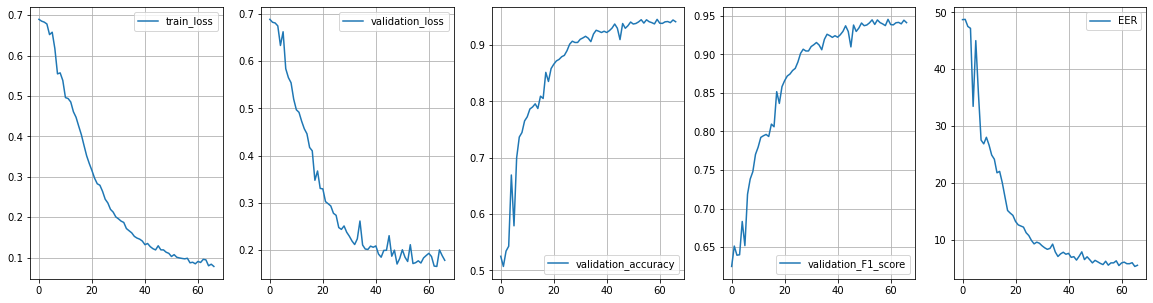

Epoch: 68/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9455067978598893 ---> 0.9471648060393963 !
Confusion Matrix of all:[[4303  182]
 [ 296 4266]]
minDCF : 0.23388968718912345% 
EER : 5.328874024506168%


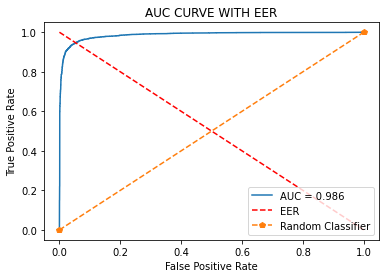

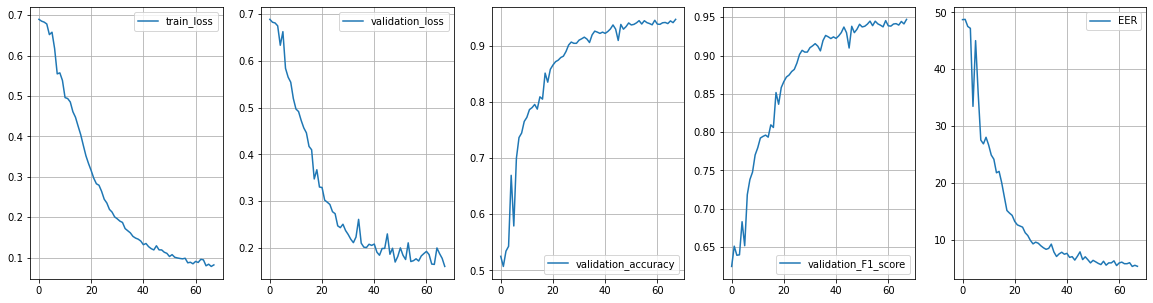

Epoch: 69/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4344  141]
 [ 338 4224]]
minDCF : 0.19321321985188458% 
EER : 5.284280936343937%


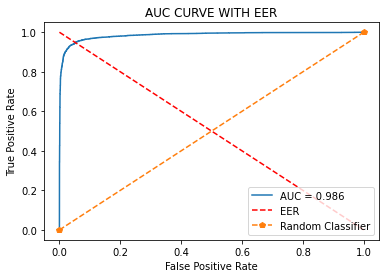

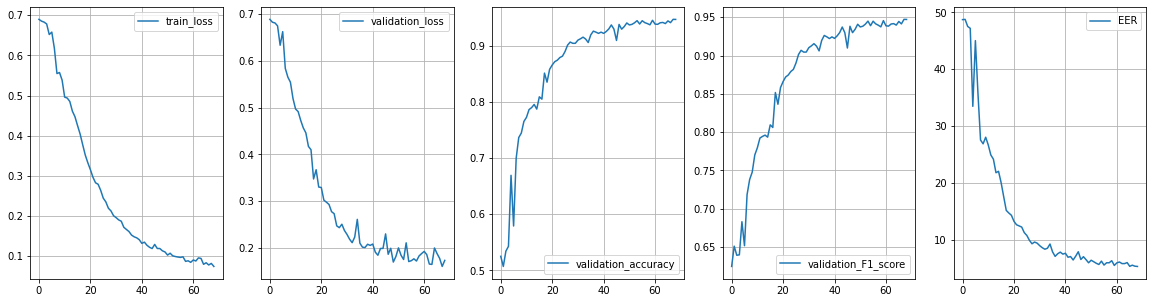

Epoch: 70/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9471648060393963 ---> 0.9472753399180301 !
Confusion Matrix of all:[[4267  218]
 [ 259 4303]]
minDCF : 0.26959212998784127% 
EER : 5.3734671126571225%


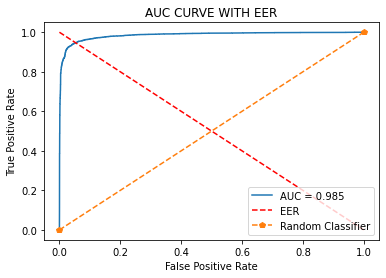

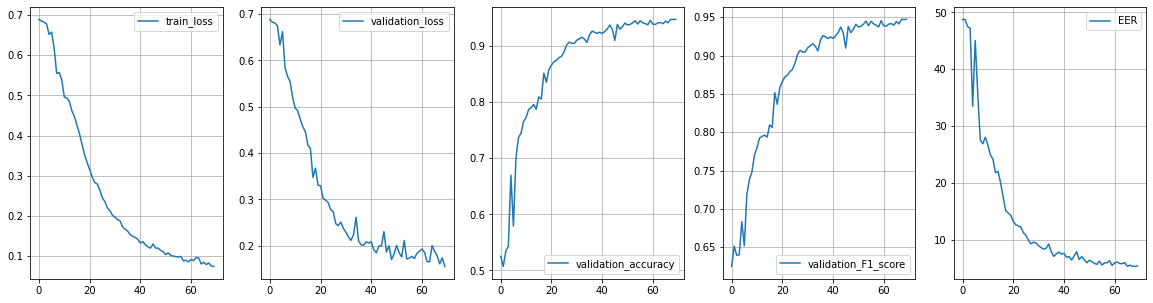

Epoch: 71/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9472753399180301 ---> 0.9476069415539315 !
Confusion Matrix of all:[[4267  218]
 [ 256 4306]]
minDCF : 0.26926052835193987% 
EER : 5.1559027937137%


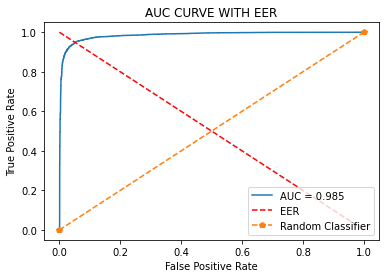

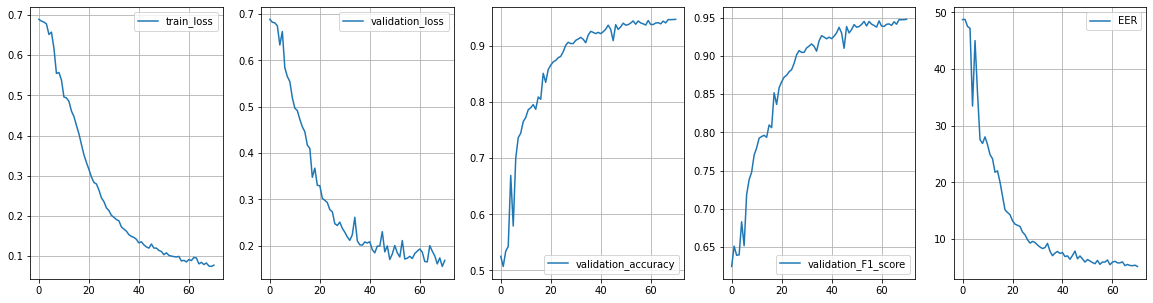

Epoch: 72/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Validation_accuracy improved from 0.9476069415539315 ---> 0.9514756273061146 !
Confusion Matrix of all:[[4295  190]
 [ 249 4313]]
minDCF : 0.23753730518403893% 
EER : 5.03552495726636%


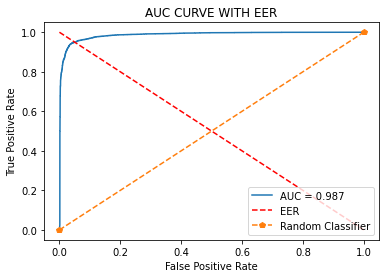

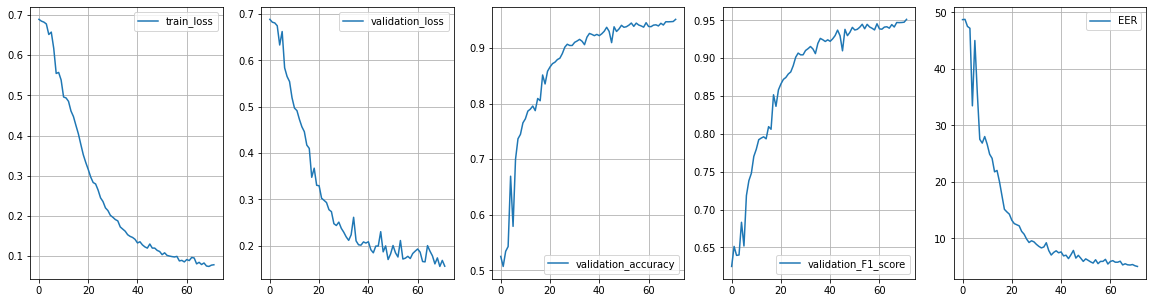

Epoch: 73/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4320  165]
 [ 326 4236]]
minDCF : 0.2184149441803913% 
EER : 5.523893029373463%


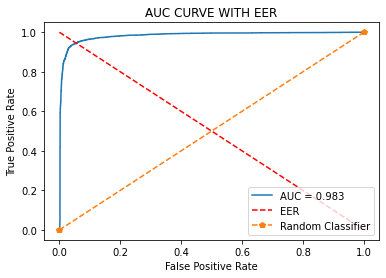

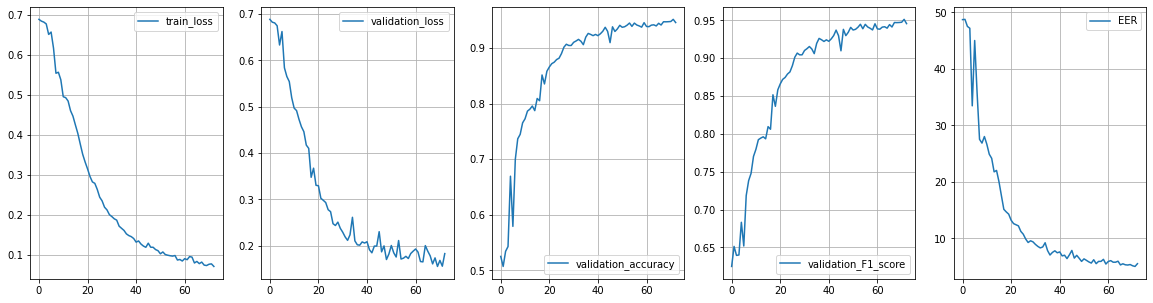

Epoch: 74/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4275  210]
 [ 297 4265]]
minDCF : 0.26494970708522164% 
EER : 5.373467112687848%


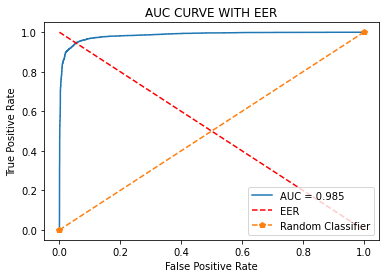

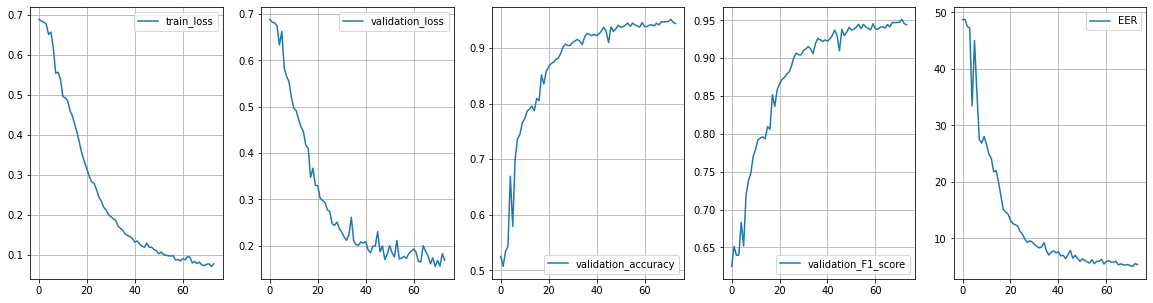

Epoch: 75/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4302  183]
 [ 320 4242]]
minDCF : 0.23764783906267273% 
EER : 5.4626532886588555%


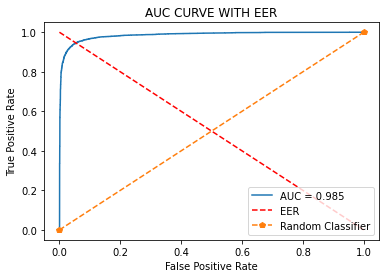

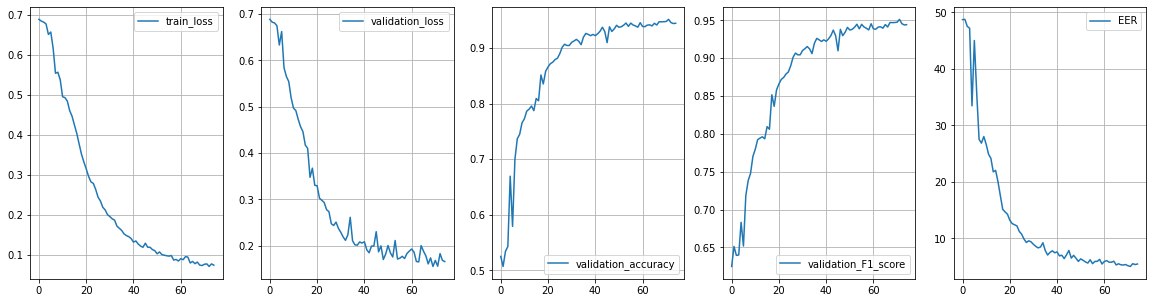

Epoch: 76/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4290  195]
 [ 329 4233]]
minDCF : 0.25190670940643306% 
EER : 5.611573871104479%


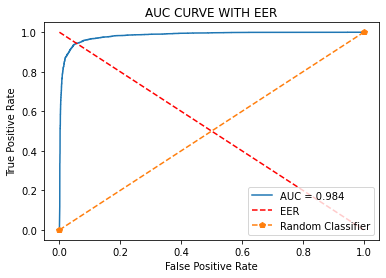

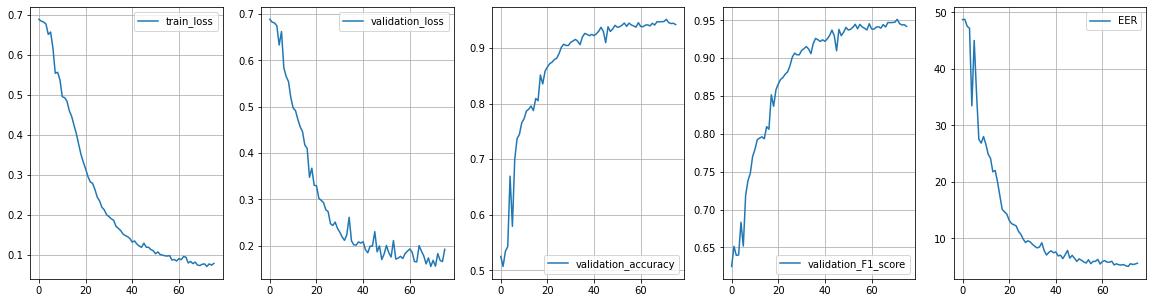

Epoch: 77/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4351  134]
 [ 342 4220]]
minDCF : 0.18591798386205372% 
EER : 5.061315496002395%


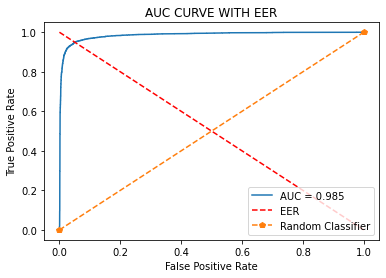

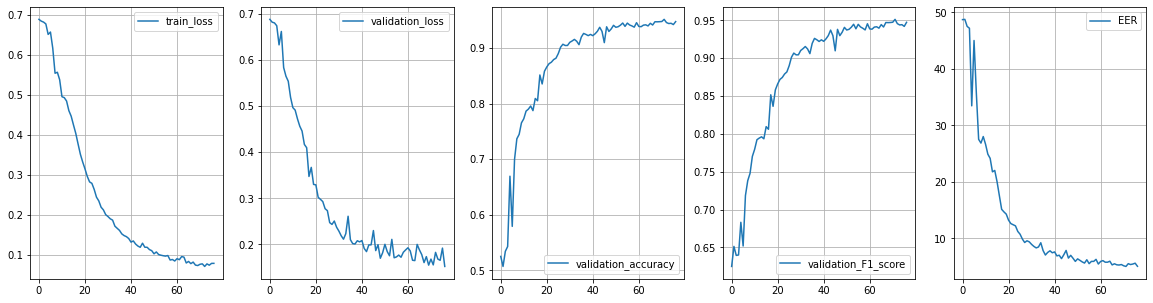

Epoch: 78/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4244  241]
 [ 236 4326]]
minDCF : 0.29247264286503816% 
EER : 5.217010083296677%


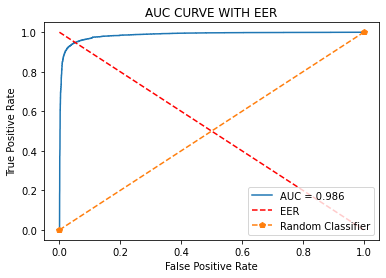

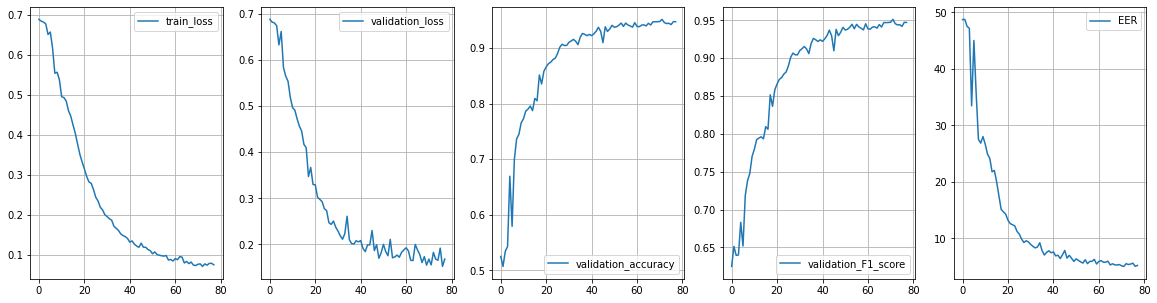

Epoch: 79/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4321  164]
 [ 319 4243]]
minDCF : 0.21653586824361667% 
EER : 5.019728189390563%


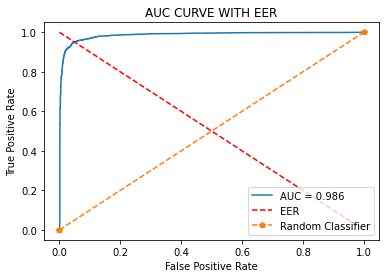

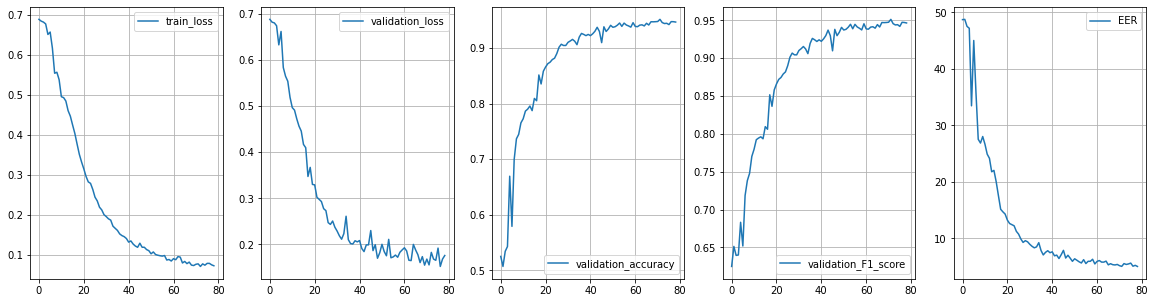

Epoch: 80/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4322  163]
 [ 298 4264]]
minDCF : 0.21310931800596883% 
EER : 4.927536231788879%


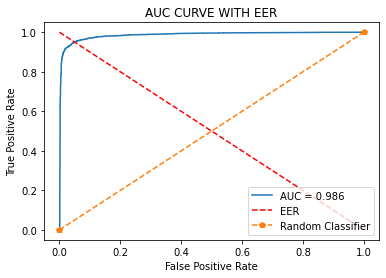

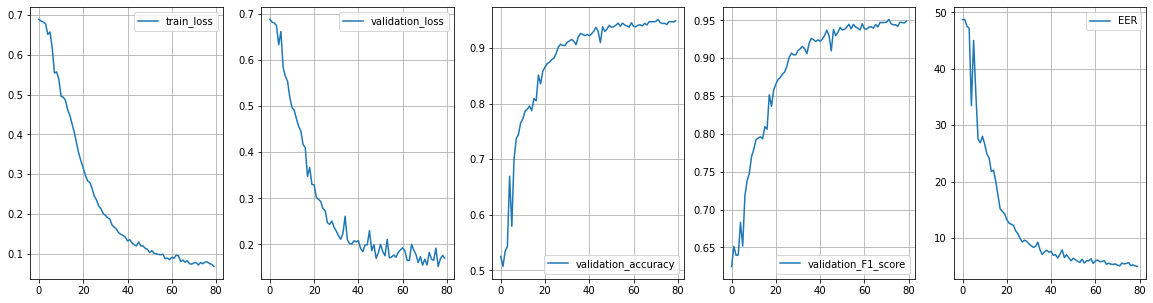

Epoch: 81/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4303  182]
 [ 257 4305]]
minDCF : 0.22957886592240526% 
EER : 4.927536231784452%


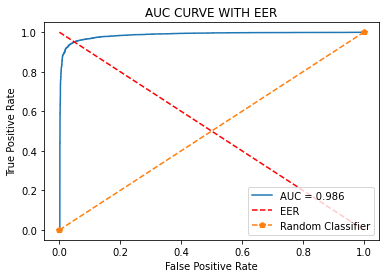

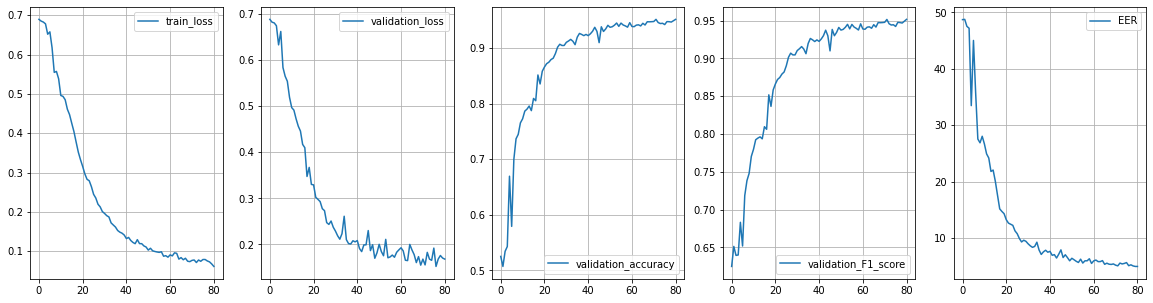

Epoch: 82/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4327  158]
 [ 305 4257]]
minDCF : 0.20835636122471538% 
EER : 4.994425863970847%


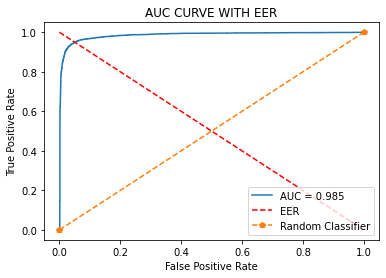

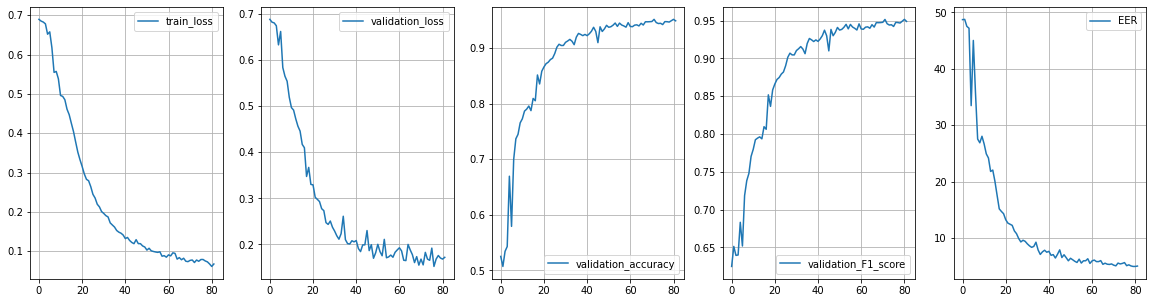

Epoch: 83/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4330  155]
 [ 315 4247]]
minDCF : 0.20614568365203934% 
EER : 5.172798216179559%


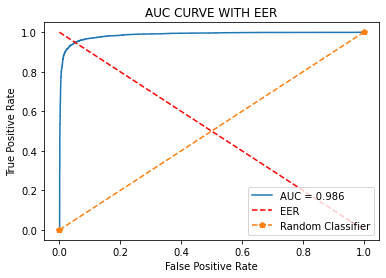

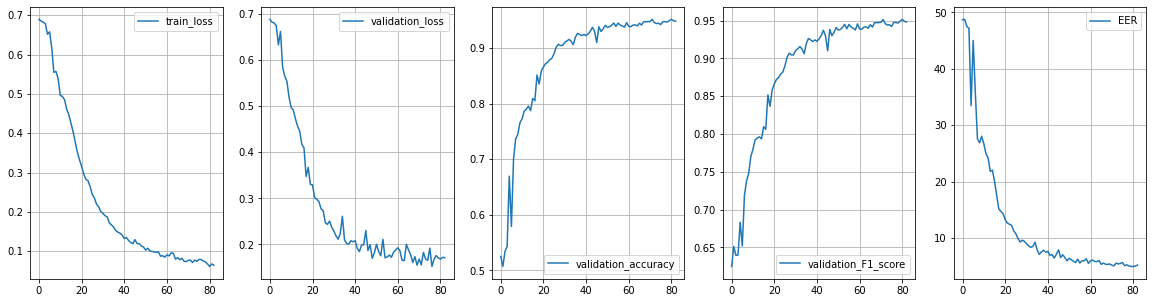

Epoch: 84/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4277  208]
 [ 245 4317]]
minDCF : 0.25699126782358794% 
EER : 5.129329241560718%


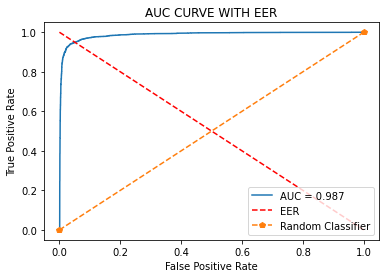

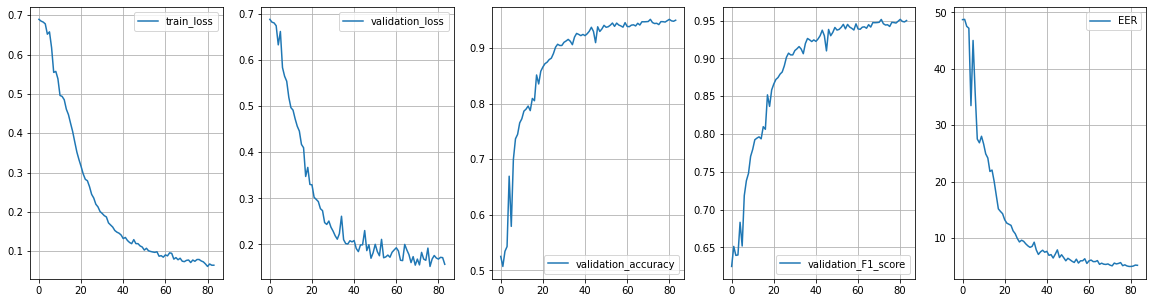

Epoch: 85/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4226  259]
 [ 261 4301]]
minDCF : 0.3151320879849674% 
EER : 5.74309513367889%


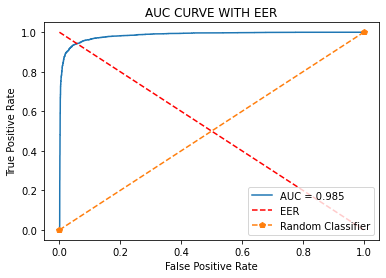

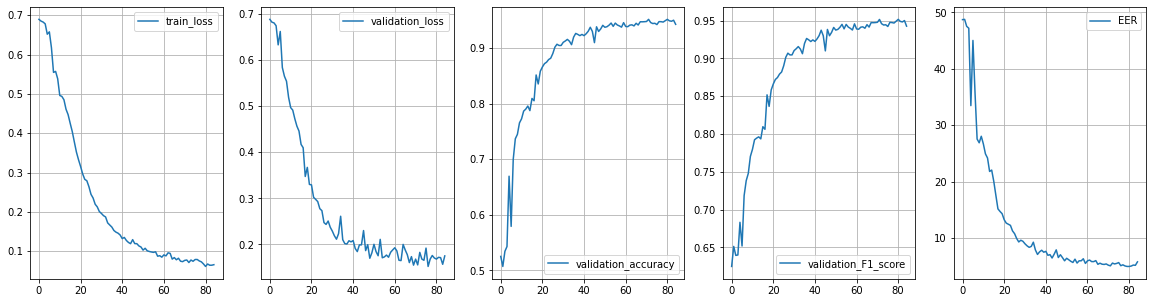

Epoch: 86/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4218  267]
 [ 205 4357]]
minDCF : 0.3177849010721786% 
EER : 5.12932924156072%


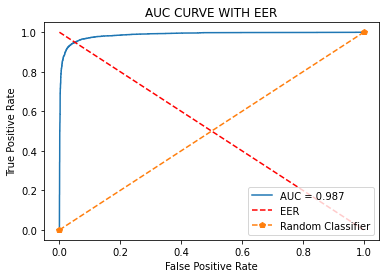

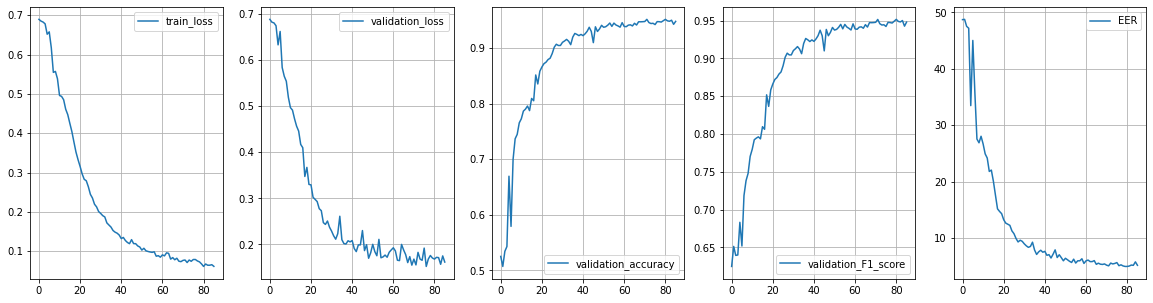

Epoch: 87/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4133  352]
 [ 332 4230]]
minDCF : 0.42577650049740245% 
EER : 7.558528427971403%


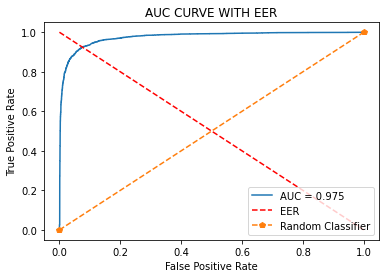

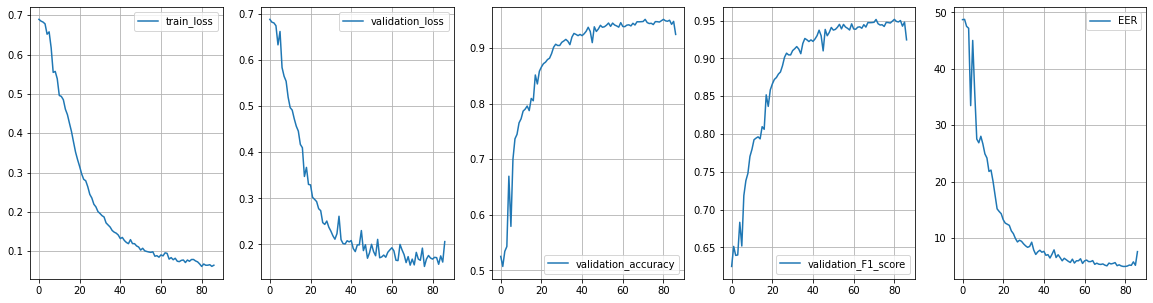

Epoch: 88/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4267  218]
 [ 319 4243]]
minDCF : 0.27622416270586936% 
EER : 6.006137658920047%


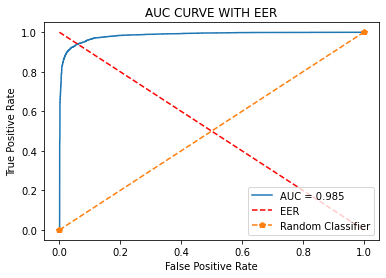

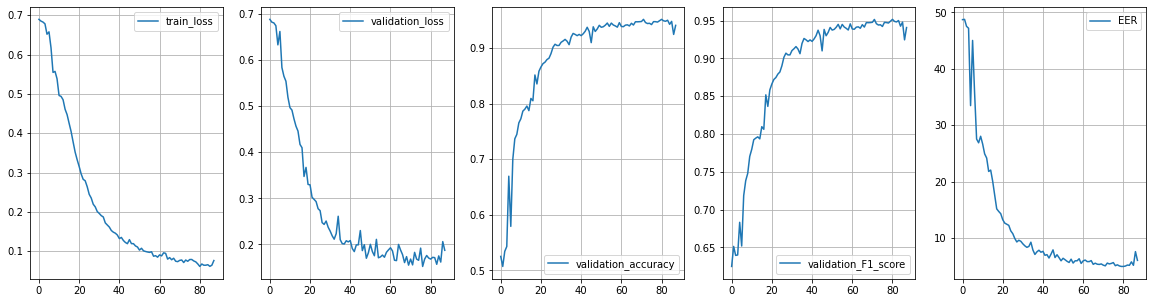

Epoch: 89/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4227  258]
 [ 264 4298]]
minDCF : 0.3143583508345308% 
EER : 5.752508361205666%


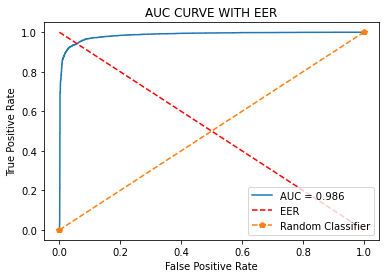

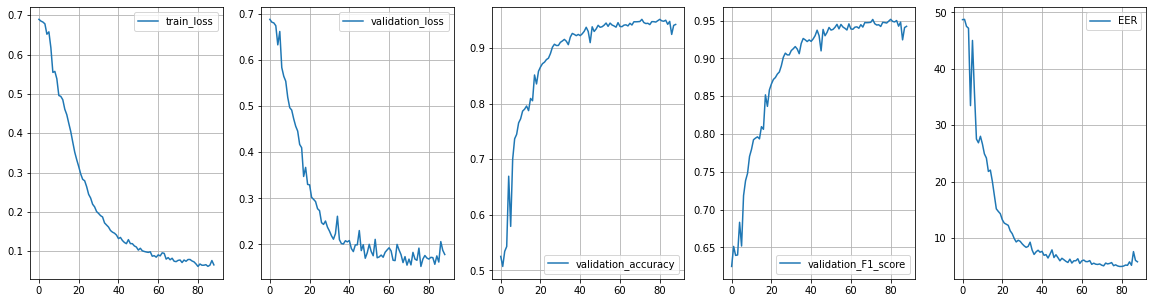

Epoch: 90/90


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4373  112]
 [ 365 4197]]
minDCF : 0.16414280977119486% 
EER : 4.838350055736768%


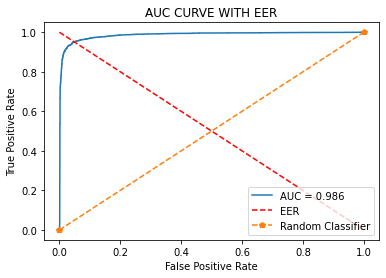

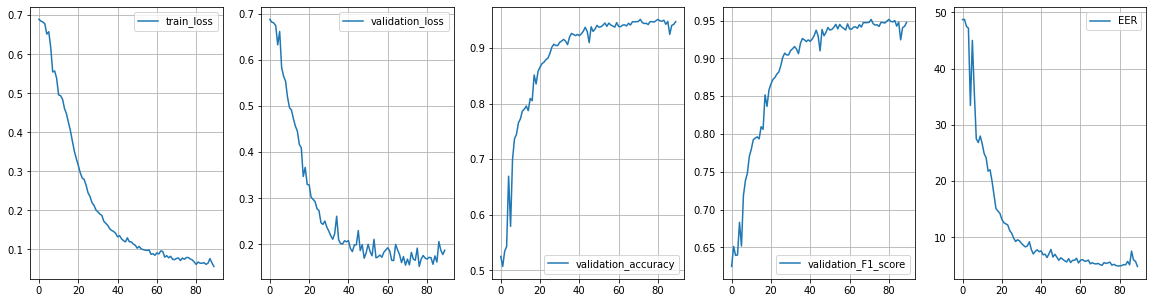

In [39]:
best_accuracy = 0
for epoch in range(1, CFG.epochs + 1):
    print(f'Epoch: {epoch}/{CFG.epochs}')
    f.write(f'Epoch: {epoch}')
    f.write('\n')
    train_loss_meter = AverageMeter()
    model.train()
####################################################################################################################
################################################## TRAINING ########################################################
####################################################################################################################


    for i, batch in enumerate(tqdm(train_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        #print(f'label:{label}')
        wav = wav.squeeze()
        #print(wav.shape)
        #mel, mel_length = featurizer(wav, length)
        output = model(wav)
        #print(output.shape)
        #print(f'output :{output.argmax(dim=-1).shape}')
        
        #print(f'label: {label.shape}')
        loss = criterion(output, label) # need class probabitities
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    
###################################################################################################################
#############################################  Validation  ########################################################
###################################################################################################################
    full_vec = []
    full_labels = []
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()
    validation_f1_meter = AverageMeter()
    validation_EER_meter = AverageMeter()
    validation_MinDCF_meter = AverageMeter()
    all_matrix = [[0,0],[0,0]]
    model.eval()
    for i, batch in enumerate(tqdm(valid_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        wav = wav.squeeze()
        with torch.no_grad():
            output = model(wav)
            loss = criterion(output, label)
            out2 = output.softmax(dim=1)
            out2 = out2.transpose(0,1)
            out2 = out2[1][:]
            out2 = out2.cpu().numpy()
            out = output.argmax(dim=-1).cpu().numpy()
            labels = label.cpu().numpy()
            full_vec.extend(out2)
            full_labels.extend(labels)
        #print(f'output :{output.argmax(dim=-1)}, label : {label}')
        
        matches = (output.argmax(dim=-1) == label).float().mean()
        f1 = f1_score(output.argmax(dim=-1).cpu(), label.cpu(), average= 'weighted')
        #print(f'Vallid:{matches.item()}')
        
        validation_loss_meter.update(loss.item(),        len(batch[0]))
        validation_accuracy_meter.update(matches.item(), len(batch[0]))
        #validation_EER_meter.update(eer[0],              len(batch[0]))
        validation_f1_meter.update(f1,                   len(batch[0]))
        
        
        matrix = confusion_matrix(labels,out)
        all_matrix+=matrix
        #print(f'F1 :{f1} , EER: {eer}')
        #print(f'Confusion Matrix of all:{all_matrix}')\
######################################## SAVE MODEL ###########################################################################

    if validation_accuracy_meter.avg > best_accuracy:
        print(f'Validation_accuracy improved from {best_accuracy} ---> {validation_accuracy_meter.avg} !')
        PATH = f"{directory}/Best_epoch_of_{CFG.model_name}.bin"
        torch.save(model.state_dict(), PATH)
        best_accuracy = validation_accuracy_meter.avg
 ###############################################################################################################################        


    
    #display.clear_output()
    mDCF = minDCF(all_matrix)
    validation_MinDCF_meter.update(mDCF)
    
    
    print(f'Confusion Matrix of all:{all_matrix}')
    print(f'minDCF : {mDCF}% ')
    plt.title('ROC CURVE WITH EER')
    fpr, tpr, _ = metrics.roc_curve(full_labels,  full_vec)
    EER = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.) * 100
    print(f'EER : {EER}%')
    
    auc = metrics.roc_auc_score(full_labels,  full_vec)
    plt.plot(fpr,tpr,label = 'AUC = %0.3f' % auc) #"AUC=%0.2f' %"+str(auc)+ '%')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [1, 0],'r--', label = 'EER')
    plt.plot([0, 1], [0, 1],'p--', label = 'Random Classifier')
    plt.legend(loc=4)
    plt.show()
    
    
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    storage['validation_F1_score'].append(validation_f1_meter.avg)
    storage['validation_EER'].append(EER)
    f.write('Validation_Loss: '+ str(validation_loss_meter.avg) + '\n')
    f.write('Validation accuracy: ' + str(validation_accuracy_meter.avg) + '\n')
    f.write('Validation_f1: '+str(validation_f1_meter.avg) + '\n')
    f.write('Validation_EER: '+str(EER) + '\n')
    f.write('Validation_MinDCF: '+ str(validation_MinDCF_meter.avg) + '%\n')
    f.write('\n\n')
    
    
    wandb.log({"Train Loss": train_loss_meter.avg, 
            "Valid Loss": validation_loss_meter.avg,
            "Valid Accuracy": validation_accuracy_meter.avg,
            "Validation F1 score": validation_f1_meter.avg,
            "Validation EER": EER,
            "Valiation mDCF":validation_MinDCF_meter.avg,
            "EER" : EER })  
############################################## PLOT ###################################################################### 
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')
    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')
    axes[3].plot(storage['validation_F1_score'], label='validation_F1_score')
    axes[4].plot(storage['validation_EER'], label='EER')
    for i in range(5):
        axes[i].grid()
        axes[i].legend()

    plt.show()
################### Save Last Epoch ##########################################
best_model_wts = copy.deepcopy(model.state_dict())
PATH = f"./{directory}/Last_epoch_of_{CFG.model_name}.bin"
torch.save(model.state_dict(), PATH)

In [40]:
run.finish()

In [41]:
best_model_wts = copy.deepcopy(model.state_dict())
PATH = f"./result/Last_epoch_of_{CFG.model_name}.bin"
torch.save(model.state_dict(), PATH)

# Test trained Model

  0%|          | 0/283 [00:00<?, ?it/s]

Confusion Matrix of all:[[4340  107]
 [ 409 4191]]
minDCF : 0.16347960649939208% 
EER : 5.059590735185945%


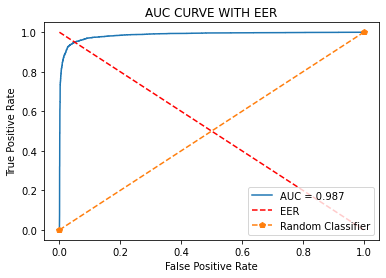

Confusion Matrix of all:[[4340  107]
 [ 409 4191]]
Accuracy on Test Dataset:0.9429645186513119 !


In [42]:
test_loss_meter = AverageMeter()
test_accuracy_meter = AverageMeter()
test_f1_meter = AverageMeter()
test_EER_meter = AverageMeter()
all_matrix = [[0,0],[0,0]]
full_vec = []
full_labels = []
for i, batch in enumerate(tqdm(test_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        wav = wav.squeeze()
        with torch.no_grad():
            output = model(wav)
            out = output.argmax(dim=-1).cpu().numpy()
            out2 = output.softmax(dim=1)
            out2 = out2.transpose(0,1)
            out2 = out2[1][:]
            out2 = out2.cpu().numpy()
            labels = label.cpu().numpy()
            full_vec.extend(out2)
            full_labels.extend(labels)
        #print(f'output :{output.argmax(dim=-1)}, label : {label}')
        
        matches = (output.argmax(dim=-1) == label).float().mean()
        f1 = f1_score(output.argmax(dim=-1).cpu(), label.cpu(), average= 'weighted')
        eer = compute_eer(labels,out)
        #print(f'Test:{matches.item()}')
        
        test_loss_meter.update(loss.item(),        len(batch[0]))
        test_accuracy_meter.update(matches.item(), len(batch[0]))
        #test_EER_meter.update(eer[0],              len(batch[0]))
        test_f1_meter.update(f1,                   len(batch[0]))
        
        
        matrix = confusion_matrix(labels,out)
        all_matrix+=matrix
        #print(f'F1 :{f1} , EER: {eer}')
        #print(f'Confusion Matrix of all:{all_matrix}')\
        
mDCF = minDCF(all_matrix)
validation_MinDCF_meter.update(mDCF)


print(f'Confusion Matrix of all:{all_matrix}')
print(f'minDCF : {mDCF}% ')
plt.title('ROC CURVE WITH EER')
fpr, tpr, _ = metrics.roc_curve(full_labels,  full_vec)
EER = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.) * 100
print(f'EER : {EER}%')

auc = metrics.roc_auc_score(full_labels,  full_vec)
plt.plot(fpr,tpr,label = 'AUC = %0.3f' % auc) #"AUC=%0.2f' %"+str(auc)+ '%')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [1, 0],'r--', label = 'EER')
plt.plot([0, 1], [0, 1],'p--', label = 'Random Classifier')
plt.legend(loc=4)
plt.show()


f.write('test_Loss: '+ str(test_loss_meter.avg) + '\n')
f.write('test accuracy: ' + str(test_accuracy_meter.avg) + '\n')
f.write('test_f1: '+str(test_f1_meter.avg) + '\n')
f.write('test_EER: '+str(EER) + '\n')
f.write('Validation_MinDCF: '+ str(validation_MinDCF_meter.avg) + '%\n')
f.write('\n\n')
#display.clear_output()
print(f'Confusion Matrix of all:{all_matrix}')
print(f'Accuracy on Test Dataset:{test_accuracy_meter.avg} !')

In [43]:
f.close()

In [44]:
matrix

array([[14,  0],
       [ 1,  8]], dtype=int64)

In [45]:
all_matrix = [[0,0],[0,0]]

In [46]:
all_matrix+=matrix

In [47]:
all_matrix


array([[14,  0],
       [ 1,  8]], dtype=int64)

In [48]:
storage['validation_F1_score']
    

[0.6247726775613812,
 0.651240888943206,
 0.6393723908788463,
 0.6399403346748291,
 0.6831515526753514,
 0.651805258963089,
 0.7185093990436184,
 0.7382147137080097,
 0.7478571773511065,
 0.7702518934983671,
 0.7796768845648332,
 0.7923335890017547,
 0.794497214099265,
 0.796164729890615,
 0.7935189250851549,
 0.8095947602847251,
 0.8061614172410481,
 0.8517345520624652,
 0.836462793489659,
 0.8582335551416468,
 0.866036865785331,
 0.872055618701052,
 0.8745957083537603,
 0.8791770266301435,
 0.881953600248021,
 0.890164003903407,
 0.901395534769394,
 0.9068410266087809,
 0.9045476677594473,
 0.9045515992388582,
 0.9102813926057342,
 0.9126671345224315,
 0.9155426267376063,
 0.9122899755240856,
 0.9061299635160217,
 0.9196548291798757,
 0.926265103580817,
 0.9244873854056783,
 0.9222230358781951,
 0.9243764361022555,
 0.9224273939456713,
 0.9256430602062568,
 0.9300032341685993,
 0.9372252621620792,
 0.929876299497883,
 0.9098633327764041,
 0.9382232904414408,
 0.9299098525600684,
 0.9

In [49]:
f1_score(out.cpu(),label.cpu(),average='weighted')

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
#fit(model, CFG.epochs , train_loader, valid_loader, optimizer, CFG.criterion, CFG.device)

## Efficcient_net predict

In [ ]:
#test = []
'./test/'
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]#os.path.join("./test",item_name)
test_dataset = UrbanSoundDataset(data, items_names, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True, drop_last=False,collate_fn=Collator())


In [ ]:
test = []
for i, batch in enumerate(tqdm(test_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)
            #print(output)
            _, pred = torch.max(output, 1) # Return values and indices
            #m = nn.Softmax(dim=1)
            #pred = m(output)
            #print(pred)
            #print(pred.item())
            #df
            test.append(classes[pred.item()])
#print(test)

In [ ]:
print(len(test))

In [ ]:
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]

In [ ]:
df = pd.DataFrame({"id" :items_names,
                   "eff": test
        
                  })

In [ ]:
df.head(2)

In [ ]:

ansamble_pred = df['eff'].to_numpy()

In [ ]:
#df.to_csv?

In [ ]:
print('Generating submission file...')
#os.chdir("./")
df.to_csv('answers.tsv',index=False, sep = '\t',header = False)

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": ansamble_pred
# #                   }

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": test
#                   })

In [ ]:
# df["class"]

In [ ]:
# df.tail(50)

In [ ]:
# df_full.tail(50)

In [ ]:
# print('Generating submission file...')
#os.chdir("./")
# df.to_csv('submission_audio.csv',index=False)

In [ ]:
# df_full.to_csv('submission_effnet7new2.csv',index=False)